# Setup (virtual environment)

In [1]:
import keras
import pickle 
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from econml.iv.nnet import DeepIV
from keras.models import load_model
%matplotlib inline

from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


- gpu check

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  0


In [4]:
keras.__version__

'2.6.0'

In [5]:
tf.__version__

'2.6.0'

# Temp Functions

In [6]:
from typing import List

def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df

def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))


In [7]:
def update_dummy_columns(row):
    row['brand_rename_{}'.format(row["brand_rename"])] = 1
    row['yyyy_{}'.format(row["yyyy"])] = 1
    row['mm_{}'.format(row["mm"])] = 1
    row['category_1_{}'.format(row["category_1"])] = 1
    return row

# 1. Load Data

In [8]:
df_model = pd.read_feather('../data/DeepIV v2.0.0.ftr')
df_model = df_model[df_model['itt_hour_ln'].notnull()]

In [9]:
df_model[['premium_perc']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

count      mean       std       min        5%       25%  \
premium_perc  16242602.0  0.362053  0.994836 -0.938326 -0.383333 -0.090909   

                   50%       75%       95%        max  
premium_perc  0.137466  0.508475  1.671756  40.936714

In [10]:
print(df_model.shape)
display(df_model.head())
display(df_model.tail())

(16242602, 219)


product_id  txn_id   yyyymm  yyyy  mm category_1 option_rename  \
0       42255   11749  2022-07  2022  07      shoes           280   
1       42255   11748  2022-07  2022  07      shoes           270   
2       42255   11747  2022-07  2022  07      shoes           270   
3       42255   11746  2022-07  2022  07      shoes           270   
4       42255   11745  2022-07  2022  07      shoes           270   

  brand_rename  itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
0         Nike     0.065580      0.278539        5.132626       10.735875   
1         Nike     1.176173      0.347032        5.132626       10.735875   
2         Nike     1.113683      0.342466        5.132626       10.735875   
3         Nike     1.479329      0.315068        5.132626       10.735875   
4         Nike     1.332659      0.242009        5.132626       10.735875   

   with_release_date  days_since_release_ln  likes_count_cumsum  \
0                  1               5.690359             53713.0   
1                  1               5.690359             53713.0   
2                  1               5.690359             53713.0   
3                  1               5.690359             53713.0   
4                  1               5.690359             53713.0   

   wish_closest_product  likes_count_cumsum_1k  likes_count_cumsum_ln  \
0                  6472                 53.713              10.891429   
1                  6472                 53.713              10.891429   
2                  6472                 53.713              10.891429   
3                  6472                 53.713              10.891429   
4                  6472                 53.713              10.891429   

   wish_closest_product_ln     VAE0      VAE1      VAE2      VAE3      VAE4  \
0                 8.775395  1.22469 -0.068803 -0.165689  0.231437 -1.084858   
1                 8.775395  1.22469 -0.068803 -0.165689  0.231437 -1.084858   
2                 8.775395  1.22469 -0.068803 -0.165689  0.231437 -1.084858   
3                 8.775395  1.22469 -0.068803 -0.165689  0.231437 -1.084858   
4                 8.775395  1.22469 -0.068803 -0.165689  0.231437 -1.084858   

       VAE5      VAE6      VAE7      VAE8      VAE9     VAE10     VAE11  \
0  0.256292  0.415015 -0.227768 -0.888845 -0.777399  0.636129 -2.119525   
1  0.256292  0.415015 -0.227768 -0.888845 -0.777399  0.636129 -2.119525   
2  0.256292  0.415015 -0.227768 -0.888845 -0.777399  0.636129 -2.119525   
3  0.256292  0.415015 -0.227768 -0.888845 -0.777399  0.636129 -2.119525   
4  0.256292  0.415015 -0.227768 -0.888845 -0.777399  0.636129 -2.119525   

      VAE12     VAE13     VAE14     VAE15     VAE16     VAE17     VAE18  \
0 -0.447786  0.089478 -0.502632  0.050769 -0.654228  0.327182 -0.983476   
1 -0.447786  0.089478 -0.502632  0.050769 -0.654228  0.327182 -0.983476   
2 -0.447786  0.089478 -0.502632  0.050769 -0.654228  0.327182 -0.983476   
3 -0.447786  0.089478 -0.502632  0.050769 -0.654228  0.327182 -0.983476   
4 -0.447786  0.089478 -0.502632  0.050769 -0.654228  0.327182 -0.983476   

      VAE19     VAE20     VAE21     VAE22     VAE23     VAE24     VAE25  \
0  1.273388  0.420625  0.321297  0.336137  0.895122  0.630526  0.752017   
1  1.273388  0.420625  0.321297  0.336137  0.895122  0.630526  0.752017   
2  1.273388  0.420625  0.321297  0.336137  0.895122  0.630526  0.752017   
3  1.273388  0.420625  0.321297  0.336137  0.895122  0.630526  0.752017   
4  1.273388  0.420625  0.321297  0.336137  0.895122  0.630526  0.752017   

      VAE26     VAE27     VAE28     VAE29     VAE30     VAE31     VAE32  \
0  1.151641  0.536488 -0.373947 -0.356338  0.716691  1.870043 -0.841526   
1  1.151641  0.536488 -0.373947 -0.356338  0.716691  1.870043 -0.841526   
2  1.151641  0.536488 -0.373947 -0.356338  0.716691  1.870043 -0.841526   
3  1.151641  0.536488 -0.373947 -0.356338  0.716691  1.870043 -0.841526   
4  1.151641  0.536488 -0.373947 -0.356338  0.716691  1.870043 -0.841526   

    

product_id  txn_id   yyyymm  yyyy  mm category_1 option_rename  \
16283582       67193    5395  2023-06  2023  06      shoes           235   
16283583       67193    5394  2023-06  2023  06      shoes           245   
16283584       67193    5393  2023-06  2023  06      shoes           275   
16283585       67193    5392  2023-06  2023  06      shoes           225   
16283586       67193    5391  2023-06  2023  06      shoes           255   

         brand_rename  itt_hour_ln  premium_perc  msrp_dollar_ln  \
16283582       Adidas     0.020347     -0.072727         3.76833   
16283583       Adidas     0.044548      0.000000         3.76833   
16283584       Adidas     0.008023     -0.090909         3.76833   
16283585       Adidas     0.011050      0.109091         3.76833   
16283586       Adidas     0.671810      0.145455         3.76833   

          brand_likes_ln  with_release_date  days_since_release_ln  \
16283582       10.200922                  0                    0.0   
16283583       10.200922                  0                    0.0   
16283584       10.200922                  0                    0.0   
16283585       10.200922                  0                    0.0   
16283586       10.200922                  0                    0.0   

          likes_count_cumsum  wish_closest_product  likes_count_cumsum_1k  \
16283582                 0.0                  1542                    0.0   
16283583                 0.0                  1542                    0.0   
16283584                 0.0                  1542                    0.0   
16283585                 0.0                  1542                    0.0   
16283586                 0.0                  1542                    0.0   

          likes_count_cumsum_ln  wish_closest_product_ln      VAE0      VAE1  \
16283582                    0.0                 7.341484 -0.863038 -0.835798   
16283583                    0.0                 7.341484 -0.863038 -0.835798   
16283584                    0.0                 7.341484 -0.863038 -0.835798   
16283585                    0.0                 7.341484 -0.863038 -0.835798   
16283586                    0.0                 7.341484 -0.863038 -0.835798   

              VAE2      VAE3      VAE4      VAE5      VAE6      VAE7     VAE8  \
16283582  0.736526 -0.232819 -0.036609  0.490917 -0.544761 -0.300737  1.64756   
16283583  0.736526 -0.232819 -0.036609  0.490917 -0.544761 -0.300737  1.64756   
16283584  0.736526 -0.232819 -0.036609  0.490917 -0.544761 -0.300737  1.64756   
16283585  0.736526 -0.232819 -0.036609  0.490917 -0.544761 -0.300737  1.64756   
16283586  0.736526 -0.232819 -0.036609  0.490917 -0.544761 -0.300737  1.64756   

              VAE9     VAE10     VAE11     VAE12    VAE13     VAE14     VAE15  \
16283582 -0.681606  1.664287  2.129067  0.208269 -1.12478 -0.420299 -1.596218   
16283583 -0.681606  1.664287  2.129067  0.208269 -1.12478 -0.420299 -1.596218   
16283584 -0.681606  1.664287  2.129067  0.208269 -1.12478 -0.420299 -1.596218   
16283585 -0.681606  1.664287  2.129067  0.208269 -1.12478 -0.420299 -1.596218   
16283586 -0.681606  1.664287  2.129067  0.208269 -1.12478 -0.420299 -1.596218   

             VAE16     VAE17     VAE18     VAE19     VAE20    VAE21     VAE22  \
16283582 -0.068161  1.103696  1.124744 -0.484753 -0.162251  0.60301  0.173355   
16283583 -0.068161  1.103696  1.124744 -0.484753 -0.162251  0.60301  0.173355   
16283584 -0.068161  1.103696  1.124744 -0.484753 -0.162251  0.60301  0.173355   
16283585 -0.068161  1.103696  1.124744 -0.484753 -0.162251  0.60301  0.173355   
16283586 -0.068161  1.103696  1.124744 -0.484753 -0.162251  0.60301  0.173355   

             VAE23     VAE24     VAE25     VAE26     VAE27     VAE28  \
16283582 -0.731974  0.746066 -0.241666 -0.065543 -0.135097  0.468187   
16283583 -0.731974  0.746066 -0.241666 -0.065543 -0.135097  0.468187   
16283584 -0.731974  0.746066 -0.241666 -0.065543 -0.135097  0.468187   
16283585 -0.731974  0.746066 -

# 2. Deep IV (241010 v5.0.0)

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [17]:
x.shape

## 1st trial

In [ ]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 256,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=SGD(learning_rate=0.0005), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

- posed because I want progress bar

In [19]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

Epoch 1/100
50759/50759 - 254s - loss: nan - val_loss: nan
Epoch 2/100
50759/50759 - 247s - loss: nan - val_loss: nan
Epoch 1/100
50759/50759 - 458s - loss: 2.2441 - val_loss: 2.6233
Epoch 2/100
50759/50759 - 455s - loss: 2.2287 - val_loss: 2.6240
Epoch 3/100


KeyboardInterrupt: 

## 2nd trial
- change optimizer to SGD with lr 0.0005 (to avoid nan loss)

In [21]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 256,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=SGD(learning_rate=0.0005), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

In [ ]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

Epoch 1/100
50759/50759 [==============================] - 242s 5ms/step - loss: nan - val_loss: nan
Epoch 2/100
50759/50759 [==============================] - 232s 5ms/step - loss: nan - val_loss: nan
Epoch 1/100
50759/50759 [==============================] - 420s 8ms/step - loss: 2.2437 - val_loss: 2.6241
Epoch 2/100
 5981/50759 [==>...........................] - ETA: 5:44 - loss: 2.2312

# 3. Deep IV (241011 v1)
- optimizer: Adam (lr = 1e-5 following Tian et al. JMR(2024) 

In [15]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [16]:
x.shape

In [17]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 256,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.00001), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-11 12:52:07.483965: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 12:52:07.488743: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-11 12:52:23.053852: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
50759/50759 [==============================] - 302s 6ms/step - loss: nan - val_loss: nan
Epoch 2/100
50759/50759 [==============================] - 293s 6ms/step - loss: nan - val_loss: nan
Epoch 1/100
50759/50759 [==============================] - 545s 11ms/step - loss: 3.2148 - val_loss: 3.2448
Epoch 2/100
50759/50759 [==============================] - 540s 11ms/step - loss: 2.4858 - val_loss: 2.7134
Epoch 3/100
50759/50759 [==============================] - 540s 11ms/step - loss: 2.2406 - val_loss: 2.6248
Epoch 4/100
50759/50759 [==============================] - 539s 11ms/step - loss: 2.2286 - val_loss: 2.6242
Epoch 5/100
50759/50759 [==============================] - 540s 11ms/step - loss: 2.2286 - val_loss: 2.6242
Epoch 6/100
50759/50759 [==============================] - 538s 11ms/step - loss: 2.2286 - val_loss: 2.6243
Epoch 7/100
50759/50759 [==============================] - 542s 11ms/step - loss: 2.2286 - val_loss: 2.6243


In [19]:
deepIvEst._effect_model.weights

[<tf.Variable 'dense_3/kernel:0' shape=(268, 128) dtype=float32, numpy=
 array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.04544382,  0.09457754, -0.09838244, ...,  0.08046503,
         -0.06239755,  0.10559104],
        [-0.1138512 , -0.09581009, -0.03179316, ..., -0.07498273,
         -0.00139593, -0.01566347],
        ...,
        [ 0.11068667,  0.0218129 ,  0.08600648, ...,  0.07884531,
          0.02640074, -0.02465294],
        [ 0.08891782,  0.10660371,  0.06035113, ...,  0.06454283,
         -0.0264533 ,  0.00829789],
        [ 0.1118198 , -0.0385946 ,  0.07996464, ...,  0.01024112,
          0.02977718,  0.10207196]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [20]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241011_v1.h5")

### predict by product

In [29]:
''' products that used in the model '''
df_product_temp = df_product[df_product['product_id'].isin(df_model_org['product_id'].unique())].drop(columns=['itt_hour_ln', 'premium_perc', 'likes_count_cumsum', 'wish_closest_product'])

''' make columns for dummies '''
col_cat = [col for col in df_model_org.columns if 'category_1_'in col]
col_yyyymm = [col for col in df_model_org.columns if 'yyyymm_'in col]

df_product_temp[col_cat] = 0
df_product_temp[col_yyyymm] = 0

''' retain column orders '''
col_order = df_product_temp.columns

''' update brand, category, yyyymm '''
df_product_temp = df_product_temp.progress_apply(update_dummy_columns, axis=1)
df_product_temp = df_product_temp[col_order]
df_product_temp = df_product_temp.set_index('product_id')

''' update option as most sold option '''
for prod in tqdm(df_product_temp.index):
    most_sold_option = dict_most_sold_option[prod]
    df_product_temp.loc[prod ,'option_rename_{}'.format(most_sold_option)] = 1

''' drop unnecessary columns '''
df_product_temp = df_product_temp[[col for col in col_order if col != 'product_id']]
df_product_temp = df_product_temp.drop(columns=['brand', 'category_1', 'yyyymm', 'option_rename'])

''' set as day it is released '''
df_product_temp['days_since_release_ln'] = 0

df_product_temp = df_product_temp[df_model_org.drop(columns=['product_id', 'itt_hour_ln', 'premium_perc', 'likes_count_cumsum_1k']).columns]

  0%|          | 0/45691 [00:00<?, ?it/s]

  0%|          | 0/45691 [00:00<?, ?it/s]

In [30]:
df_product_temp.head()

msrp_dollar_ln  with_release_date  days_since_release_ln  \
product_id                                                             
25786             4.875197                  1                      0   
25789             4.527624                  1                      0   
25790             5.259097                  1                      0   
25793             5.132626                  1                      0   
25795             3.994666                  1                      0   

            brand_likes_ln      VAE0      VAE1      VAE2      VAE3      VAE4  \
product_id                                                                     
25786            10.200922  0.676309 -1.575297 -0.043607  0.873860  1.298814   
25789             9.483492 -0.278353  0.819924 -0.039145  0.603112 -2.189820   
25790            10.735875  1.163760  0.885189 -0.297457 -2.080920 -0.859893   
25793            10.735875  0.086730 -1.304507 -0.273956 -0.847463  0.531882   
25795             9.483492  0.681207  0.452544 -0.598607  0.722640  0.497241   

                VAE5      VAE6      VAE7      VAE8      VAE9     VAE10  \
product_id                                                               
25786      -0.955692 -2.439239 -1.271508 -1.820027 -1.109349  1.496022   
25789       0.288556  1.251366  0.212509  0.259735 -2.244585  0.137665   
25790      -0.463905 -0.175836  1.372599  1.666972 -2.209720 -0.713546   
25793      -0.741701  0.429611  0.113153  1.846475  1.441151 -0.640763   
25795      -1.143429 -0.616232  0.730699 -0.240117  0.203906 -0.740641   

               VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
product_id                                                               
25786       0.322924  1.464733  0.447997 -0.786919  0.211732  0.913748   
25789       0.839325 -0.937997  0.282958 -0.801766 -0.109573 -1.159306   
25790       0.237316  0.267760  1.210201 -0.838115 -0.428373 -1.241643   
25793      -0.264189 -1.082078 -0.149280 -0.348963 -0.854676 -0.009027   
25795      -0.363998 -0.550855 -0.007757 -0.724930  0.813892  0.278385   

               VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
product_id                                                               
25786       0.543296 -0.584219  1.017928  1.558922  1.311388 -0.736336   
25789      -1.356433  0.369816 -1.406017  0.042679  0.844974 -0.272164   
25790      -1.194112 -0.650041  0.583215 -1.441559 -0.933574  0.752938   
25793      -1.556341 -0.196377  1.914592  2.104369 -1.469481  0.790414   
25795       0.801133  0.550301  0.160388  0.090791  1.600908  0.983192   

               VAE23     VAE24     VAE25     VAE26     VAE27     VAE28  \
product_id                                                               
25786       1.201367  0.970808 -0.116500  0.048287  0.335001  0.218430   
25789       1.546223 -0.240610  0.883583 -1.459104 -0.127660 -0.550372   
25790       0.959186 -0.633304 -0.714078 -0.495411  0.650863 -0.300245   
25793       0.228840 -0.056590 -0.651810 -2.534421 -0.266226 -0.036463   
25795      -1.302951 -0.469957  2.402856 -0.332017 -0.923364  1.621303   

               VAE29     VAE30     VAE31     VAE32     VAE33     VAE34  \
product_id                                                               
25786       0.902921 -1.829400 -0.426615 -0.208741  1.003136  0.905561   
25789       1.244388  0.327254 -0.139561 -0.086274  0.663570 -1.007079   
25790       1.262393  0.508080 -0.049219  0.369089 -0.256466  0.250020   
25793      -0.329294  1.448291  0.214455 -0.884462  0.630107 -0.060249   
25795       0.560736  0.992692 -0.192482  0.257626  0.319515  1.341307   

               VAE35     VAE36     VAE37     VAE38     VAE39     VAE40  \
product_id                                                               
25786       0.559745  1.055308  0.892231 -0.448187 -1.287703 -0.169677   
25789       3.161897 -0.895671 -2.134882  0.644888 -0.698604 -1.141175   
25790      -1.446614  0.651404  1.219553  2.825877 -0.0

In [43]:
df_product_temp.loc[prd].sum()

In [46]:
dict_results = {}
t_range = np.arange(-0.95, 1.67, 0.01)
for prd in tqdm(df_product_temp.index):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (262, 1)))]).T.rename(columns={0:'premium_perc', 1:'pred_itt_hour_log'})
    df_pred['pred_itt_hour_log'] = df_pred['pred_itt_hour_log'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

  0%|          | 0/45691 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
df_pred_results = pd.concat(dict_results.values())

In [40]:
display(df_pred_results.head())
display(df_pred_results.tail())

premium_perc  pred_itt_hour_log  product_id
0        -0.95            1.24535       25786
1        -0.94            1.24535       25786
2        -0.93            1.24535       25786
3        -0.92            1.24535       25786
4        -0.91            1.24535       25786

premium_perc  pred_itt_hour_log  product_id
257         1.62            1.24535      134285
258         1.63            1.24535      134285
259         1.64            1.24535      134285
260         1.65            1.24535      134285
261         1.66            1.24535      134285

<Axes: xlabel='premium_perc'>

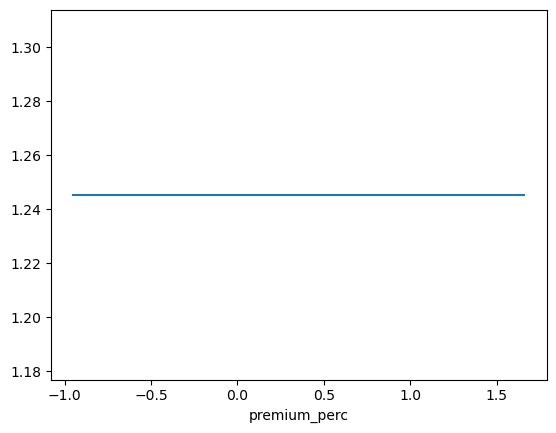

In [36]:
df_pred_results.groupby(['premium_perc'])['pred_itt_hour_log'].mean().plot()

In [ ]:
''' save prediction results '''
df_pred_results.reset_index(drop=True).to_feather("../model/model_prediction_241011_v1.ftr")

### load model and replicate

In [ ]:
loaded_effect_model = load_model("2_analysis/data/3_model/Deep IV/241009 v2/DeepIV_batch1000prods_100epochs (_effect_model).h5")

In [ ]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 256,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.00001), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

In [ ]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

''' fit Deep IV by 50 products batch '''
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

In [ ]:
model_test._effect_model = loaded_effect_model

In [ ]:
dict_results = {}
t_range = np.arange(-0.95, 1.67, 0.01)
for prd in tqdm(df_product_temp.index):
    df_pred = pd.DataFrame([t_range, model_test.predict(t_range, np.tile(df_product_temp.loc[prd], (262, 1)))]).T.rename(columns={0:'premium', 1:'pred_itt_hour_log'})
    df_pred['pred_itt_hour_log'] = df_pred['pred_itt_hour_log'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

In [ ]:
display(df_pred_results.head())
display(df_pred_results.tail())

# 4. Deep IV (241014 v2)
- optimizer: SGD (lr = 0.000001 following Tian et al. JMR(2024)
- batch size: 128

## prep data

In [12]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])
dict_most_sold_option = df_model.groupby(['product_id', 'option_rename'], as_index=False).size().sort_values(by=['product_id', 'size'], ascending=[True, False]).drop_duplicates(subset='product_id', keep='first').set_index('product_id')['option_rename'].to_dict()

In [13]:
''' oragnize columns and make dummy columns '''
df_model['likes_count_cumsum_1k'] = df_model['likes_count_cumsum'] / 1000
df_model_org = df_model[['product_id', 'itt_hour_ln', 'premium_perc', 'category_1', 'yyyymm', 'brand_likes_ln', 'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', 'likes_count_cumsum_1k'] + [col for col in df_model.columns if "VAE" in col]]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyymm'],  dtype=np.int8))

''' oragnize columns and make dummy columns '''
df_model['likes_count_cumsum_1k'] = df_model['likes_count_cumsum'] / 1000
df_model_org = df_model[['product_id', 'itt_hour_ln', 'premium_perc', 'category_1', 'brand', 'yyyymm', 'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', 'likes_count_cumsum_1k'] + [col for col in df_model.columns if "VAE" in col]]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'brand', 'yyyymm'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 271)


product_id  itt_hour_ln  premium_perc  brand_likes_ln  msrp_dollar_ln  \
0       25785     0.213991      0.053254        9.522666        4.875197   
1       25785     0.294120     -0.035503        9.522666        4.875197   
2       25785     0.179772      0.005917        9.522666        4.875197   
3       25785     0.222477     -0.023669        9.522666        4.875197   
4       25785     0.112088      0.000000        9.522666        4.875197   

   with_release_date  days_since_release_ln  likes_count_cumsum_1k      VAE0  \
0                  1               6.787845                  1.697  1.688273   
1                  1               6.787845                  1.697  1.688273   
2                  1               6.787845                  1.697  1.688273   
3                  1               6.787845                  1.697  1.688273   
4                  1               6.787845                  1.697  1.688273   

       VAE1      VAE2      VAE3      VAE4      VAE5      VAE6      VAE7  \
0  0.887339 -0.117374 -1.385981  0.413938  0.074346  0.200774 -0.997213   
1  0.887339 -0.117374 -1.385981  0.413938  0.074346  0.200774 -0.997213   
2  0.887339 -0.117374 -1.385981  0.413938  0.074346  0.200774 -0.997213   
3  0.887339 -0.117374 -1.385981  0.413938  0.074346  0.200774 -0.997213   
4  0.887339 -0.117374 -1.385981  0.413938  0.074346  0.200774 -0.997213   

       VAE8      VAE9     VAE10     VAE11     VAE12     VAE13     VAE14  \
0  1.285838  0.419133  0.216886 -0.674666 -1.693699  2.447318  0.190503   
1  1.285838  0.419133  0.216886 -0.674666 -1.693699  2.447318  0.190503   
2  1.285838  0.419133  0.216886 -0.674666 -1.693699  2.447318  0.190503   
3  1.285838  0.419133  0.216886 -0.674666 -1.693699  2.447318  0.190503   
4  1.285838  0.419133  0.216886 -0.674666 -1.693699  2.447318  0.190503   

      VAE15     VAE16     VAE17     VAE18     VAE19     VAE20     VAE21  \
0 -0.317794 -1.100298  1.278041  1.140656  0.082711 -1.113478  0.620378   
1 -0.317794 -1.100298  1.278041  1.140656  0.082711 -1.113478  0.620378   
2 -0.317794 -1.100298  1.278041  1.140656  0.082711 -1.113478  0.620378   
3 -0.317794 -1.100298  1.278041  1.140656  0.082711 -1.113478  0.620378   
4 -0.317794 -1.100298  1.278041  1.140656  0.082711 -1.113478  0.620378   

      VAE22     VAE23     VAE24     VAE25     VAE26     VAE27     VAE28  \
0 -1.195107  1.640626 -0.176389 -1.115997 -1.482354  0.571948  0.777121   
1 -1.195107  1.640626 -0.176389 -1.115997 -1.482354  0.571948  0.777121   
2 -1.195107  1.640626 -0.176389 -1.115997 -1.482354  0.571948  0.777121   
3 -1.195107  1.640626 -0.176389 -1.115997 -1.482354  0.571948  0.777121   
4 -1.195107  1.640626 -0.176389 -1.115997 -1.482354  0.571948  0.777121   

      VAE29     VAE30     VAE31     VAE32     VAE33     VAE34     VAE35  \
0 -0.127269 -0.705201 -0.012049  1.502452  0.590448 -0.074854 -1.501808   
1 -0.127269 -0.705201 -0.012049  1.502452  0.590448 -0.074854 -1.501808   
2 -0.127269 -0.705201 -0.012049  1.502452  0.590448 -0.074854 -1.501808   
3 -0.127269 -0.705201 -0.012049  1.502452  0.590448 -0.074854 -1.501808   
4 -0.127269 -0.705201 -0.012049  1.502452  0.590448 -0.074854 -1.501808   

      VAE36    VAE37     VAE38     VAE39     VAE40     VAE41   VAE42  \
0 -0.283437 -0.52912  1.164206  0.622821 -0.218422 -1.173577 -0.5901   
1 -0.283437 -0.52912  1.164206  0.622821 -0.218422 -1.173577 -0.5901   
2 -0.283437 -0.52912  1.164206  0.622821 -0.218422 -1.173577 -0.5901   
3 -0.283437 -0.52912  1.164206  0.622821 -0.218422 -1.173577 -0.5901   
4 -0.283437 -0.52912  1.164206  0.622821 -0.218422 -1.173577 -0.5901   

      VAE43    VAE44    VAE45     VAE46     VAE47     VAE48     VAE49  \
0  0.322662 -0.56384 -1.21063 -0.961995  0.354674  0.465221 -0.833342   
1  0.322662 -0.56384 -1.21063 -0.961995  0.354674  0.465221 -0.833342   
2  0.322662 -0.56384 -1.21063 -0.961995  0.354674  0.465221 -0.833342   
3  0.322662 -0.56384 -1.21063 -0.961995  0.354674  0.465221 -0.833342   
4  0.322662 

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [16]:
x.shape

In [20]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1]+1,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=SGD(learning_rate=0.0000005), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-14 07:44:20.405260: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 07:44:20.408348: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-14 07:44:37.405972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
101517/101517 [==============================] - 324s 3ms/step - loss: nan - val_loss: nan
Epoch 2/100
101517/101517 [==============================] - 324s 3ms/step - loss: nan - val_loss: nan
Epoch 1/100
101517/101517 [==============================] - 599s 6ms/step - loss: 3.6311 - val_loss: 4.0173
Epoch 2/100
101517/101517 [==============================] - 597s 6ms/step - loss: 3.3734 - val_loss: 3.7725
Epoch 3/100
101517/101517 [==============================] - 584s 6ms/step - loss: 3.1630 - val_loss: 3.5715
Epoch 4/100
101517/101517 [==============================] - 591s 6ms/step - loss: 2.9913 - val_loss: 3.4065
Epoch 5/100
101517/101517 [==============================] - 590s 6ms/step - loss: 2.8512 - val_loss: 3.2710
Epoch 6/100
101517/101517 [==============================] - 594s 6ms/step - loss: 2.7368 - val_loss: 3.1596
Epoch 7/100
101517/101517 [==============================] - 592s 6ms/step - loss: 2.6434 - val_loss: 3.0679
Epoch 8/100
101517/101517 [====

In [22]:
deepIvEst._effect_model.weights

[<tf.Variable 'dense_3/kernel:0' shape=(268, 128) dtype=float32, numpy=
 array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.10718536,  0.0989053 ,  0.08263245, ..., -0.03039004,
          0.09973401,  0.02382532],
        [ 0.0273388 ,  0.02785546,  0.10135101, ..., -0.03918774,
          0.11563091, -0.08854499],
        ...,
        [ 0.05104417,  0.08393274,  0.06430647, ..., -0.09436996,
          0.07976027, -0.09357955],
        [ 0.04010126,  0.01342824, -0.01290069, ...,  0.11718808,
          0.06234901, -0.11286894],
        [ 0.08188768,  0.02920124, -0.01243119, ..., -0.12029836,
         -0.1114576 , -0.05010118]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [23]:
deepIvEst._d_y

In [24]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241014_v2.h5")

## predict by product

In [25]:
''' products that used in the model '''
df_product_temp = df_product[df_product['product_id'].isin(df_model_org['product_id'].unique())].drop(columns=['itt_hour_ln', 'premium_perc', 'likes_count_cumsum', 'wish_closest_product'])

''' make columns for dummies '''
col_cat = [col for col in df_model_org.columns if 'category_1_'in col]
col_yyyy = [col for col in df_model_org.columns if 'yyyy_'in col]
col_mm = [col for col in df_model_org.columns if 'mm_'in col]
col_brand = [col for col in df_model_org.columns if 'brand_rename_'in col]

df_product_temp[col_cat] = 0
df_product_temp[col_yyyy] = 0
df_product_temp[col_mm] = 0
df_product_temp[col_brand] = 0

''' retain column orders '''
col_order = df_product_temp.columns

''' update brand, category, yyyymm '''
df_product_temp = df_product_temp.progress_apply(update_dummy_columns, axis=1)
df_product_temp = df_product_temp[col_order]
df_product_temp = df_product_temp.set_index('product_id')

''' update option as most sold option '''
for prod in tqdm(df_product_temp.index):
    most_sold_option = dict_most_sold_option[prod]
    df_product_temp.loc[prod ,'option_rename_{}'.format(most_sold_option)] = 1

''' drop unnecessary columns '''
df_product_temp = df_product_temp[[col for col in col_order if col != 'product_id']]
df_product_temp = df_product_temp.drop(columns=['category_1', 'yyyy' ,'mm', 'brand_rename'])

''' set as day it is released '''
df_product_temp['days_since_release_ln'] = 0

df_product_temp = df_product_temp[df_model_org.drop(columns=['product_id', 'itt_hour_ln', 'premium_perc', 'likes_count_cumsum_1k']).columns]

  0%|          | 0/45691 [00:00<?, ?it/s]

  0%|          | 0/45691 [00:00<?, ?it/s]

In [26]:
df_product_temp.head()

brand_likes_ln  msrp_dollar_ln  with_release_date  \
product_id                                                      
25786            10.200922        4.875197                  1   
25789             9.483492        4.527624                  1   
25790            10.735875        5.259097                  1   
25793            10.735875        5.132626                  1   
25795             9.483492        3.994666                  1   

            days_since_release_ln      VAE0      VAE1      VAE2      VAE3  \
product_id                                                                  
25786                           0  0.676309 -1.575297 -0.043607  0.873860   
25789                           0 -0.278353  0.819924 -0.039145  0.603112   
25790                           0  1.163760  0.885189 -0.297457 -2.080920   
25793                           0  0.086730 -1.304507 -0.273956 -0.847463   
25795                           0  0.681207  0.452544 -0.598607  0.722640   

                VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
product_id                                                               
25786       1.298814 -0.955692 -2.439239 -1.271508 -1.820027 -1.109349   
25789      -2.189820  0.288556  1.251366  0.212509  0.259735 -2.244585   
25790      -0.859893 -0.463905 -0.175836  1.372599  1.666972 -2.209720   
25793       0.531882 -0.741701  0.429611  0.113153  1.846475  1.441151   
25795       0.497241 -1.143429 -0.616232  0.730699 -0.240117  0.203906   

               VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
product_id                                                               
25786       1.496022  0.322924  1.464733  0.447997 -0.786919  0.211732   
25789       0.137665  0.839325 -0.937997  0.282958 -0.801766 -0.109573   
25790      -0.713546  0.237316  0.267760  1.210201 -0.838115 -0.428373   
25793      -0.640763 -0.264189 -1.082078 -0.149280 -0.348963 -0.854676   
25795      -0.740641 -0.363998 -0.550855 -0.007757 -0.724930  0.813892   

               VAE16     VAE17     VAE18     VAE19     VAE20     VAE21  \
product_id                                                               
25786       0.913748  0.543296 -0.584219  1.017928  1.558922  1.311388   
25789      -1.159306 -1.356433  0.369816 -1.406017  0.042679  0.844974   
25790      -1.241643 -1.194112 -0.650041  0.583215 -1.441559 -0.933574   
25793      -0.009027 -1.556341 -0.196377  1.914592  2.104369 -1.469481   
25795       0.278385  0.801133  0.550301  0.160388  0.090791  1.600908   

               VAE22     VAE23     VAE24     VAE25     VAE26     VAE27  \
product_id                                                               
25786      -0.736336  1.201367  0.970808 -0.116500  0.048287  0.335001   
25789      -0.272164  1.546223 -0.240610  0.883583 -1.459104 -0.127660   
25790       0.752938  0.959186 -0.633304 -0.714078 -0.495411  0.650863   
25793       0.790414  0.228840 -0.056590 -0.651810 -2.534421 -0.266226   
25795       0.983192 -1.302951 -0.469957  2.402856 -0.332017 -0.923364   

               VAE28     VAE29     VAE30     VAE31     VAE32     VAE33  \
product_id                                                               
25786       0.218430  0.902921 -1.829400 -0.426615 -0.208741  1.003136   
25789      -0.550372  1.244388  0.327254 -0.139561 -0.086274  0.663570   
25790      -0.300245  1.262393  0.508080 -0.049219  0.369089 -0.256466   
25793      -0.036463 -0.329294  1.448291  0.214455 -0.884462  0.630107   
25795       1.621303  0.560736  0.992692 -0.192482  0.257626  0.319515   

               VAE34     VAE35     VAE36     VAE37     VAE38     VAE39  \
product_id                                                               
25786       0.905561  0.559745  1.055308  0.892231 -0.448187 -1.287703   
25789      -1.007079  3.161897 -0.895671 -2.134882  0.644888 -0.698604   
25790       0.250020 -1.446614  0.651404  1.219553  2.825877 -0.098712   
25793      -0.060249 -0.227609  0.527446 -1.557917 

In [27]:
dict_results = {}
t_range = np.arange(-0.95, 1.67, 0.01)
for prd in tqdm(df_product_temp.index[:50]):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (262, 1)))]).T.rename(columns={0:'premium_perc', 1:'pred_itt_hour_log'})
    df_pred['pred_itt_hour_log'] = df_pred['pred_itt_hour_log'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
display(df_pred_results.head())
display(df_pred_results.tail())

premium_perc  pred_itt_hour_log  product_id
0        -0.95           1.244764       25786
1        -0.94           1.244764       25786
2        -0.93           1.244764       25786
3        -0.92           1.244764       25786
4        -0.91           1.244764       25786

premium_perc  pred_itt_hour_log  product_id
257         1.62           1.244764       25860
258         1.63           1.244764       25860
259         1.64           1.244764       25860
260         1.65           1.244764       25860
261         1.66           1.244764       25860

In [29]:
dict_results = {}
t_range = np.arange(-0.95, 1.67, 0.01)
for prd in tqdm(df_product_temp.index):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (262, 1)))]).T.rename(columns={0:'premium_perc', 1:'pred_itt_hour_log'})
    df_pred['pred_itt_hour_log'] = df_pred['pred_itt_hour_log'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

  0%|          | 0/45691 [00:00<?, ?it/s]

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x767fe1292af0>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/deepiv/lib/python3.9/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "/home/ubuntu/anaconda3/envs/deepiv/lib/python3.9/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
''' save prediction results '''
df_pred_results.reset_index(drop=True).to_feather("../model/model_prediction_241014_v2.ftr")

# 5. Deep IV (241015 v1)
- learning rate: 0.000001
- deepen the model layers and introduce batch normalization
- add gradient clipping

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

''' oragnize columns and make dummy columns '''
df_model['likes_count_cumsum_1k'] = df_model['likes_count_cumsum'] / 1000
df_model_org = df_model[['product_id', 'itt_hour_ln', 'premium_perc', 'category_1', 'brand', 'yyyymm', 'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', 'likes_count_cumsum_1k'] + [col for col in df_model.columns if "VAE" in col]]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'brand', 'yyyymm'],  dtype=np.int8))

In [17]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  likes_count_cumsum_1k     VAE0      VAE1      VAE2  \
0                5.69036              53.713001  1.22469 -0.068803 -0.165689   
1                5.69036              53.713001  1.22469 -0.068803 -0.165689   
2                5.69036              53.713001  1.22469 -0.068803 -0.165689   
3                5.69036              53.713001  1.22469 -0.068803 -0.165689   
4                5.69036              53.713001  1.22469 -0.068803 -0.165689   

       VAE3      VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
0  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
1  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
2  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
3  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
4  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   

      VAE10     VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   

      VAE17     VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
0  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
1  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
2  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
3  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
4  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   

      VAE24     VAE25     VAE26     VAE27     VAE28     VAE29     VAE30  \
0  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
1  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
2  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
3  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
4  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   

      VAE31     VAE32     VAE33     VAE34     VAE35     VAE36     VAE37  \
0  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
1  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
2  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
3  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
4  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   

      VAE38     VAE39     VAE40     VAE41    VAE42     VAE43     VAE44  \
0  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
1  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
2  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
3  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
4  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   

      VAE45     VAE46     VAE47     VAE48     VAE49     VAE50    VAE51  \
0 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
1 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
2 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
3 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [19]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [28]:
x.shape

In [29]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(256, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(128, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(256, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(128, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1)
                                ])


keras_fit_options = { "epochs": 1,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=SGD(learning_rate=0.000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-15 06:09:39.715703: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 06:09:39.719953: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [30]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-15 06:10:00.012383: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


101517/101517 [==============================] - 1284s 13ms/step - loss: 5.2391 - val_loss: 5.3441


In [31]:
deepIvEst._effect_model.weights

[<tf.Variable 'dense_4/kernel:0' shape=(327, 256) dtype=float32, numpy=
 array([[ 0.03388554,  0.03839535,  0.07025615, ..., -0.08600796,
         -0.0842436 , -0.01497526],
        [-0.08152734, -0.04219404, -0.08858071, ..., -0.003106  ,
         -0.07199913,  0.0405761 ],
        [-0.02538724,  0.05322326,  0.06888892, ..., -0.01795426,
          0.04529161,  0.05277019],
        ...,
        [-0.0677075 ,  0.02699876,  0.05976118, ..., -0.09835394,
         -0.08264424, -0.07373438],
        [-0.02242534, -0.03221712,  0.09642317, ..., -0.04817836,
          0.03948135,  0.01007276],
        [-0.01333666, -0.04345085, -0.02038809, ...,  0.04468768,
          0.01241381, -0.08570826]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(256,) dtype=float32, numpy=
 array([ 4.22344820e-05, -3.70535447e-04,  1.12624322e-04,  1.81813884e-04,
        -2.31799087e-04,  6.35430915e-05, -3.05879221e-04,  4.45137957e-05,
         2.91771576e-04,  1.62183569e-04,  1.50744090e-04,  1.89929

In [32]:
deepIvEst._d_y

In [33]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241015_v1.h5")

## predict by product

In [21]:
''' products that used in the model '''
df_product_temp = df_product[df_product['product_id'].isin(df_model_org['product_id'].unique())].drop(columns=['itt_hour_ln', 'premium_perc', 'likes_count_cumsum', 'wish_closest_product'])

''' make columns for dummies '''
col_cat = [col for col in df_model_org.columns if 'category_1_'in col]
col_yyyy = [col for col in df_model_org.columns if 'yyyy_'in col]
col_mm = [col for col in df_model_org.columns if 'mm_'in col]
col_brand = [col for col in df_model_org.columns if 'brand_rename_'in col]

df_product_temp[col_cat] = 0
df_product_temp[col_yyyy] = 0
df_product_temp[col_mm] = 0
df_product_temp[col_brand] = 0

''' retain column orders '''
col_order = df_product_temp.columns

''' update brand, category, yyyymm '''
df_product_temp = df_product_temp.progress_apply(update_dummy_columns, axis=1)
df_product_temp = df_product_temp[col_order]
df_product_temp = df_product_temp.set_index('product_id')

''' drop unnecessary columns '''
df_product_temp = df_product_temp[[col for col in col_order if col != 'product_id']]

df_product_temp = df_product_temp.drop(columns=['brand_rename', 'category_1', 'yyyymm', 'yyyy', 'mm', 'option_rename'])

''' set as day it is released '''
df_product_temp['days_since_release_ln'] = 0
df_product_temp = df_product_temp[df_model_org.drop(columns=['product_id', 'itt_hour_ln', 'premium_perc', 'likes_count_cumsum_1k']).columns]

  0%|          | 0/45691 [00:00<?, ?it/s]

In [34]:
df_product_temp.head()

msrp_dollar_ln  with_release_date  days_since_release_ln  \
product_id                                                             
42258             4.986238                  1                      0   
42260             4.345801                  0                      0   
42264             4.345801                  1                      0   
42265             4.345801                  1                      0   
42267             3.559734                  0                      0   

                VAE0      VAE1      VAE2      VAE3      VAE4      VAE5  \
product_id                                                               
42258       1.050903  0.111212  1.969807  0.246390 -1.691035  0.429657   
42260      -1.738925  1.827212 -0.856622  0.113211  1.747071 -0.296775   
42264      -1.299457  0.878780  0.184898  0.791323 -0.357866 -0.494414   
42265      -2.419938  0.905033  0.281696 -0.900049  0.511693  1.126570   
42267      -2.057883 -0.494335 -0.015157 -0.787079  0.716884  2.681304   

                VAE6      VAE7      VAE8      VAE9     VAE10     VAE11  \
product_id                                                               
42258       0.948235 -0.536632 -1.214658 -0.964641  1.480959 -0.783705   
42260       0.624815 -1.126044 -1.021075  0.356013 -0.571247  2.460512   
42264       0.796174  1.631406  0.376148 -0.844294 -0.286660 -0.520856   
42265       0.176529  2.128669 -0.431294  0.625473  0.268541  0.764545   
42267       0.544064  1.506283  1.119234 -1.538718 -1.114949  0.461781   

               VAE12     VAE13     VAE14     VAE15     VAE16     VAE17  \
product_id                                                               
42258       0.466241 -0.688015 -0.412942 -0.143428 -0.314078 -0.618858   
42260      -0.971897  0.425472  1.226174  1.521232  0.047381 -1.149022   
42264       0.207794  0.388311  0.360393 -1.016000  0.201387  0.099013   
42265       0.166856 -1.415028  1.257951 -0.380420 -0.161390 -0.056215   
42267      -0.444077 -0.349623 -0.603524  0.124092 -0.593204 -0.416332   

               VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
product_id                                                               
42258       0.846497  0.046871 -0.369871  0.740456  0.270468 -3.159378   
42260      -0.584600  0.857650  0.634725  0.505800 -2.420990 -0.709899   
42264       0.068639 -0.755147  1.492694 -0.693865  0.641771 -0.081320   
42265      -0.933749  0.807526 -0.816335 -0.542718  0.195698 -0.251901   
42267      -0.919334  1.043153  1.249755  0.186249 -0.807491  0.413206   

               VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
product_id                                                               
42258      -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
42260      -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
42264      -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
42265      -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
42267       0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

               VAE30     VAE31     VAE32     VAE33     VAE34     VAE35  \
product_id                                                               
42258      -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188   
42260       0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845   
42264      -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256   
42265       0.404087 -0.199356  1.724285  0.789555  0.877525  0.491653   
42267       1.082721 -0.412045  0.877310  0.962479  0.013337  0.162370   

               VAE36     VAE37     VAE38     VAE39     VAE40     VAE41  \
product_id                                                               
42258       0.549174  1.383650 -0.624311 -0.903093 -1.980773 -1.410958   
42260      -2.168412 -0.198054 -0.060278 -0.402895 -2.182614 -2.512765   
42264      -0.166063  0.734578 -0.425735  0.942472  0.150544  0.766455   
42265      -0.328331 -0

In [35]:
df_product_temp.shape

In [37]:
dict_results = {}
t_range = np.arange(-0.95, 2.00, 0.01)
for prd in tqdm(df_product_temp.index[:100]):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (len(t_range), 1)))]).T.rename(columns={0:'premium_perc', 1:'itt_hour_log_pred'})
    df_pred['itt_hour_log_pred'] = df_pred['itt_hour_log_pred'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

  0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
df_pred_results = pd.concat(dict_results.values())

In [39]:
display(df_pred_results.head())
display(df_pred_results.tail())

premium_perc  itt_hour_log_pred  product_id
0        -0.95           0.098323       42258
1        -0.94           0.097980       42258
2        -0.93           0.097644       42258
3        -0.92           0.097307       42258
4        -0.91           0.096944       42258

premium_perc  itt_hour_log_pred  product_id
290         1.95          -0.504551       42620
291         1.96          -0.504198       42620
292         1.97          -0.503843       42620
293         1.98          -0.503489       42620
294         1.99          -0.503135       42620

<Axes: xlabel='premium_perc'>

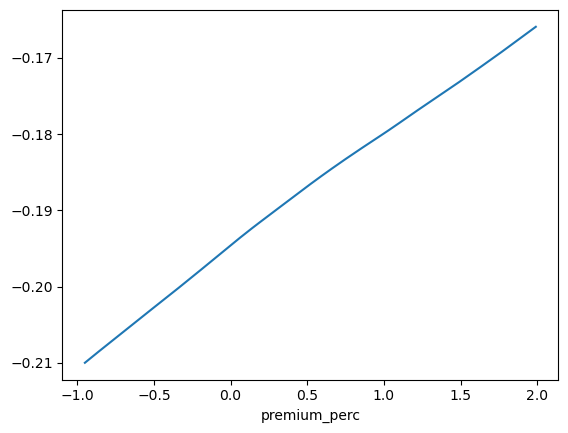

In [41]:
df_pred_results.groupby(['premium_perc'])['itt_hour_log_pred'].mean().plot()

# 6. Deep IV (241015 v2)
- learning rate: 0.000005

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [15]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

''' oragnize columns and make dummy columns '''
df_model['likes_count_cumsum_1k'] = df_model['likes_count_cumsum'] / 1000
df_model_org = df_model[['product_id', 'itt_hour_ln', 'premium_perc', 'category_1', 'brand', 'yyyymm', 'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', 'likes_count_cumsum_1k'] + [col for col in df_model.columns if "VAE" in col]]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'brand', 'yyyymm'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  likes_count_cumsum_1k     VAE0      VAE1      VAE2  \
0                5.69036              53.713001  1.22469 -0.068803 -0.165689   
1                5.69036              53.713001  1.22469 -0.068803 -0.165689   
2                5.69036              53.713001  1.22469 -0.068803 -0.165689   
3                5.69036              53.713001  1.22469 -0.068803 -0.165689   
4                5.69036              53.713001  1.22469 -0.068803 -0.165689   

       VAE3      VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
0  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
1  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
2  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
3  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
4  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   

      VAE10     VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   

      VAE17     VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
0  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
1  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
2  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
3  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
4  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   

      VAE24     VAE25     VAE26     VAE27     VAE28     VAE29     VAE30  \
0  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
1  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
2  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
3  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
4  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   

      VAE31     VAE32     VAE33     VAE34     VAE35     VAE36     VAE37  \
0  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
1  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
2  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
3  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
4  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   

      VAE38     VAE39     VAE40     VAE41    VAE42     VAE43     VAE44  \
0  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
1  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
2  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
3  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
4  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   

      VAE45     VAE46     VAE47     VAE48     VAE49     VAE50    VAE51  \
0 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
1 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
2 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
3 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [16]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [17]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [18]:
x.shape

In [19]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(256, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(128, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(256, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(128, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1)
                                ])


keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=SGD(learning_rate=0.000005, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-15 06:45:23.844201: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 06:45:23.846673: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-15 06:45:55.480907: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
101517/101517 [==============================] - 623s 6ms/step - loss: 0.9937 - val_loss: 0.6832
Epoch 2/100
101517/101517 [==============================] - 609s 6ms/step - loss: 0.8685 - val_loss: 0.6097
Epoch 3/100
101517/101517 [==============================] - 612s 6ms/step - loss: 0.7436 - val_loss: 0.5515
Epoch 4/100
101517/101517 [==============================] - 604s 6ms/step - loss: 0.6383 - val_loss: 0.5182
Epoch 5/100
101517/101517 [==============================] - 603s 6ms/step - loss: 0.5521 - val_loss: 0.4961
Epoch 6/100
101517/101517 [==============================] - 615s 6ms/step - loss: nan - val_loss: nan
Epoch 7/100
101517/101517 [==============================] - 608s 6ms/step - loss: nan - val_loss: nan
Epoch 1/100
101517/101517 [==============================] - 1275s 13ms/step - loss: 4.2946 - val_loss: 5475199.5000
Epoch 2/100
 15720/101517 [===>..........................] - ETA: 16:59 - loss: 3.7137


KeyboardInterrupt



# 7. Deep IV (241015 v3)
- learning rate: 0.000005 --> 0.0000001

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  likes_count_cumsum_1k     VAE0      VAE1      VAE2  \
0                5.69036              53.713001  1.22469 -0.068803 -0.165689   
1                5.69036              53.713001  1.22469 -0.068803 -0.165689   
2                5.69036              53.713001  1.22469 -0.068803 -0.165689   
3                5.69036              53.713001  1.22469 -0.068803 -0.165689   
4                5.69036              53.713001  1.22469 -0.068803 -0.165689   

       VAE3      VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
0  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
1  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
2  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
3  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
4  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   

      VAE10     VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   

      VAE17     VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
0  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
1  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
2  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
3  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
4  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   

      VAE24     VAE25     VAE26     VAE27     VAE28     VAE29     VAE30  \
0  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
1  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
2  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
3  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
4  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   

      VAE31     VAE32     VAE33     VAE34     VAE35     VAE36     VAE37  \
0  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
1  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
2  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
3  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
4  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   

      VAE38     VAE39     VAE40     VAE41    VAE42     VAE43     VAE44  \
0  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
1  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
2  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
3  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
4  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   

      VAE45     VAE46     VAE47     VAE48     VAE49     VAE50    VAE51  \
0 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
1 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
2 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
3 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [17]:
x.shape

In [18]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(256, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(128, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(256, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(128, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1)
                                ])


keras_fit_options = { "epochs": 10,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=SGD(learning_rate=0.0000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-15 11:09:13.775815: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 11:09:13.778329: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-15 11:09:32.582704: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
101517/101517 [==============================] - 611s 6ms/step - loss: 1.0686 - val_loss: 0.7217
Epoch 2/10
101517/101517 [==============================] - 621s 6ms/step - loss: 1.0672 - val_loss: 0.7218
Epoch 3/10
101517/101517 [==============================] - 612s 6ms/step - loss: 1.0655 - val_loss: 0.7203
Epoch 4/10
101517/101517 [==============================] - 604s 6ms/step - loss: 1.0642 - val_loss: 0.7221
Epoch 5/10
101517/101517 [==============================] - 601s 6ms/step - loss: 1.0624 - val_loss: 0.7346
Epoch 1/10
 19707/101517 [====>.........................] - ETA: 16:01 - loss: 6.4946


KeyboardInterrupt



In [ ]:
deepIvEst._effect_model.weights

In [ ]:
deepIvEst._d_y

In [ ]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241015_v3.h5")

# 8. Deep IV (241015 v4)
- reduce model layers
- optimizer: SGD --> Adam

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  likes_count_cumsum_1k     VAE0      VAE1      VAE2  \
0                5.69036              53.713001  1.22469 -0.068803 -0.165689   
1                5.69036              53.713001  1.22469 -0.068803 -0.165689   
2                5.69036              53.713001  1.22469 -0.068803 -0.165689   
3                5.69036              53.713001  1.22469 -0.068803 -0.165689   
4                5.69036              53.713001  1.22469 -0.068803 -0.165689   

       VAE3      VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
0  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
1  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
2  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
3  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
4  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   

      VAE10     VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   

      VAE17     VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
0  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
1  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
2  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
3  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
4  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   

      VAE24     VAE25     VAE26     VAE27     VAE28     VAE29     VAE30  \
0  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
1  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
2  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
3  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
4  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   

      VAE31     VAE32     VAE33     VAE34     VAE35     VAE36     VAE37  \
0  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
1  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
2  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
3  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
4  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   

      VAE38     VAE39     VAE40     VAE41    VAE42     VAE43     VAE44  \
0  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
1  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
2  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
3  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
4  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   

      VAE45     VAE46     VAE47     VAE48     VAE49     VAE50    VAE51  \
0 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
1 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
2 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
3 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [17]:
x.shape

In [18]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
    
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1)
                                ])


keras_fit_options = { "epochs": 100,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.0000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-15 12:25:54.141134: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 12:25:54.146107: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-15 12:26:13.135493: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
101517/101517 [==============================] - 583s 6ms/step - loss: 0.9801 - val_loss: 0.7252
Epoch 2/100
101517/101517 [==============================] - 577s 6ms/step - loss: 0.9434 - val_loss: 0.7001
Epoch 3/100
101517/101517 [==============================] - 575s 6ms/step - loss: 0.9076 - val_loss: 0.6703
Epoch 4/100
101517/101517 [==============================] - 573s 6ms/step - loss: 0.8729 - val_loss: 0.6501
Epoch 5/100
101517/101517 [==============================] - 578s 6ms/step - loss: 0.8391 - val_loss: 0.6332
Epoch 6/100
101517/101517 [==============================] - 580s 6ms/step - loss: 0.8062 - val_loss: 0.6205
Epoch 7/100
101517/101517 [==============================] - 580s 6ms/step - loss: 0.7742 - val_loss: 0.5949
Epoch 8/100
101517/101517 [==============================] - 579s 6ms/step - loss: 0.7423 - val_loss: 0.5766
Epoch 9/100
101517/101517 [==============================] - 573s 6ms/step - loss: 0.7119 - val_loss: 0.5647
Epoch 10/100
101517

In [20]:
deepIvEst._effect_model.weights

[<tf.Variable 'dense_3/kernel:0' shape=(327, 128) dtype=float32, numpy=
 array([[-0.11003836, -0.11384508,  0.04567159, ..., -0.08364721,
          0.05563232, -0.10802212],
        [-0.03343949, -0.0500365 , -0.05525667, ...,  0.01592744,
          0.00158781, -0.0968473 ],
        [-0.03075282,  0.03430943,  0.08369161, ..., -0.07836964,
         -0.02497024, -0.01216386],
        ...,
        [-0.01345162,  0.06739493,  0.02265408, ..., -0.11206464,
          0.00664886, -0.06124628],
        [-0.07593502, -0.06927072,  0.00170044, ...,  0.10518494,
          0.09879609,  0.04589275],
        [ 0.08133329, -0.04614062, -0.0529268 , ...,  0.1058795 ,
         -0.02392102,  0.00627289]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 9.65337269e-04, -1.15629949e-03,  1.77605590e-03,  1.35099559e-04,
         6.04302506e-04, -9.72970563e-04, -5.66020957e-04, -3.17638944e-04,
        -1.53635672e-04,  5.80389169e-04, -2.42474474e-04, -7.05221

In [21]:
deepIvEst._d_y

In [22]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241015_v4.h5")

## predict by product

In [23]:
''' products that used in the model '''
df_product_temp = df_product[df_product['product_id'].isin(df_model_org['product_id'].unique())].drop(columns=['itt_hour_ln', 'premium_perc', 'likes_count_cumsum', 'wish_closest_product'])

''' make columns for dummies '''
col_cat = [col for col in df_model_org.columns if 'category_1_'in col]
col_yyyy = [col for col in df_model_org.columns if 'yyyy_'in col]
col_mm = [col for col in df_model_org.columns if 'mm_'in col]
col_brand = [col for col in df_model_org.columns if 'brand_rename_'in col]

df_product_temp[col_cat] = 0
df_product_temp[col_yyyy] = 0
df_product_temp[col_mm] = 0
df_product_temp[col_brand] = 0

''' retain column orders '''
col_order = df_product_temp.columns

''' update brand, category, yyyymm '''
df_product_temp = df_product_temp.progress_apply(update_dummy_columns, axis=1)
df_product_temp = df_product_temp[col_order]
df_product_temp = df_product_temp.set_index('product_id')

''' drop unnecessary columns '''
df_product_temp = df_product_temp[[col for col in col_order if col != 'product_id']]

df_product_temp = df_product_temp.drop(columns=['brand_rename', 'category_1', 'yyyymm', 'yyyy', 'mm', 'option_rename'])

''' set as day it is released '''
df_product_temp['days_since_release_ln'] = 0
df_product_temp = df_product_temp[df_model_org.drop(columns=['product_id', 'itt_hour_ln', 'premium_perc', 'likes_count_cumsum_1k']).columns]

  0%|          | 0/45691 [00:00<?, ?it/s]

In [24]:
df_product_temp.head()

msrp_dollar_ln  with_release_date  days_since_release_ln  \
product_id                                                             
42258             4.986238                  1                      0   
42260             4.345801                  0                      0   
42264             4.345801                  1                      0   
42265             4.345801                  1                      0   
42267             3.559734                  0                      0   

                VAE0      VAE1      VAE2      VAE3      VAE4      VAE5  \
product_id                                                               
42258       1.050903  0.111212  1.969807  0.246390 -1.691035  0.429657   
42260      -1.738925  1.827212 -0.856622  0.113211  1.747071 -0.296775   
42264      -1.299457  0.878780  0.184898  0.791323 -0.357866 -0.494414   
42265      -2.419938  0.905033  0.281696 -0.900049  0.511693  1.126570   
42267      -2.057883 -0.494335 -0.015157 -0.787079  0.716884  2.681304   

                VAE6      VAE7      VAE8      VAE9     VAE10     VAE11  \
product_id                                                               
42258       0.948235 -0.536632 -1.214658 -0.964641  1.480959 -0.783705   
42260       0.624815 -1.126044 -1.021075  0.356013 -0.571247  2.460512   
42264       0.796174  1.631406  0.376148 -0.844294 -0.286660 -0.520856   
42265       0.176529  2.128669 -0.431294  0.625473  0.268541  0.764545   
42267       0.544064  1.506283  1.119234 -1.538718 -1.114949  0.461781   

               VAE12     VAE13     VAE14     VAE15     VAE16     VAE17  \
product_id                                                               
42258       0.466241 -0.688015 -0.412942 -0.143428 -0.314078 -0.618858   
42260      -0.971897  0.425472  1.226174  1.521232  0.047381 -1.149022   
42264       0.207794  0.388311  0.360393 -1.016000  0.201387  0.099013   
42265       0.166856 -1.415028  1.257951 -0.380420 -0.161390 -0.056215   
42267      -0.444077 -0.349623 -0.603524  0.124092 -0.593204 -0.416332   

               VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
product_id                                                               
42258       0.846497  0.046871 -0.369871  0.740456  0.270468 -3.159378   
42260      -0.584600  0.857650  0.634725  0.505800 -2.420990 -0.709899   
42264       0.068639 -0.755147  1.492694 -0.693865  0.641771 -0.081320   
42265      -0.933749  0.807526 -0.816335 -0.542718  0.195698 -0.251901   
42267      -0.919334  1.043153  1.249755  0.186249 -0.807491  0.413206   

               VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
product_id                                                               
42258      -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
42260      -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
42264      -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
42265      -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
42267       0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

               VAE30     VAE31     VAE32     VAE33     VAE34     VAE35  \
product_id                                                               
42258      -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188   
42260       0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845   
42264      -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256   
42265       0.404087 -0.199356  1.724285  0.789555  0.877525  0.491653   
42267       1.082721 -0.412045  0.877310  0.962479  0.013337  0.162370   

               VAE36     VAE37     VAE38     VAE39     VAE40     VAE41  \
product_id                                                               
42258       0.549174  1.383650 -0.624311 -0.903093 -1.980773 -1.410958   
42260      -2.168412 -0.198054 -0.060278 -0.402895 -2.182614 -2.512765   
42264      -0.166063  0.734578 -0.425735  0.942472  0.150544  0.766455   
42265      -0.328331 -0

In [25]:
df_product_temp.shape

In [27]:
dict_results = {}
t_range = np.arange(-0.95, 2.00, 0.01)
for prd in tqdm(df_product_temp.index[:100]):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (len(t_range), 1)))]).T.rename(columns={0:'premium_perc', 1:'itt_hour_log_pred'})
    df_pred['itt_hour_log_pred'] = df_pred['itt_hour_log_pred'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
df_pred_results = pd.concat(dict_results.values())
display(df_pred_results.head())
display(df_pred_results.tail())

premium_perc  itt_hour_log_pred  product_id
0        -0.95          -0.894559       42258
1        -0.94          -0.894122       42258
2        -0.93          -0.893684       42258
3        -0.92          -0.893247       42258
4        -0.91          -0.892809       42258

premium_perc  itt_hour_log_pred  product_id
290         1.95          -0.348051       42620
291         1.96          -0.347848       42620
292         1.97          -0.347646       42620
293         1.98          -0.347444       42620
294         1.99          -0.347242       42620

<Axes: xlabel='premium_perc'>

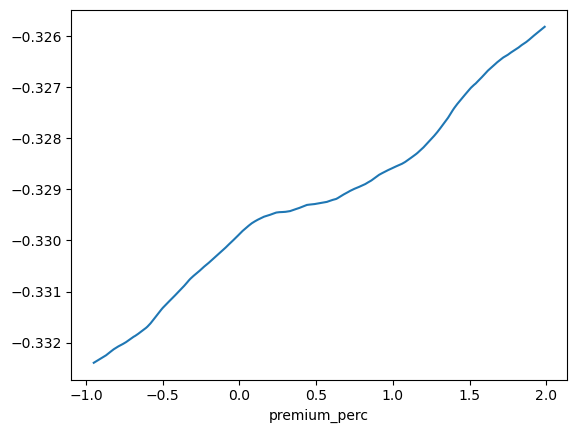

In [29]:
df_pred_results.groupby(['premium_perc'])['itt_hour_log_pred'].mean().plot()

In [30]:
''' save prediction results '''
df_pred_results.reset_index(drop=True).to_feather("../model/model_prediction_241015_v4.ftr")

# 9. Deep IV (241016 v1)
- early stopping patience=3
- epoch 200
- put Relu function on the response model

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  likes_count_cumsum_1k     VAE0      VAE1      VAE2  \
0                5.69036              53.713001  1.22469 -0.068803 -0.165689   
1                5.69036              53.713001  1.22469 -0.068803 -0.165689   
2                5.69036              53.713001  1.22469 -0.068803 -0.165689   
3                5.69036              53.713001  1.22469 -0.068803 -0.165689   
4                5.69036              53.713001  1.22469 -0.068803 -0.165689   

       VAE3      VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
0  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
1  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
2  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
3  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
4  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   

      VAE10     VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   

      VAE17     VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
0  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
1  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
2  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
3  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
4  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   

      VAE24     VAE25     VAE26     VAE27     VAE28     VAE29     VAE30  \
0  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
1  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
2  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
3  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
4  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   

      VAE31     VAE32     VAE33     VAE34     VAE35     VAE36     VAE37  \
0  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
1  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
2  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
3  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
4  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   

      VAE38     VAE39     VAE40     VAE41    VAE42     VAE43     VAE44  \
0  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
1  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
2  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
3  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
4  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   

      VAE45     VAE46     VAE47     VAE48     VAE49     VAE50    VAE51  \
0 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
1 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
2 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
3 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
df_model_org[['itt_hour_ln']].describe().T

count      mean       std  min       25%       50%      75%  \
itt_hour_ln  16242602.0  1.256262  1.498069  0.0  0.132732  0.619082  1.90839   

                   max  
itt_hour_ln  10.402765

In [17]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [18]:
x.shape

In [19]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
    
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1, activation='relu')
                                ])


keras_fit_options = { "epochs": 200,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.0000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-15 23:44:01.107052: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 23:44:01.112557: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-15 23:44:20.384816: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
101517/101517 [==============================] - 637s 6ms/step - loss: 1.0460 - val_loss: 0.7891
Epoch 2/200
101517/101517 [==============================] - 620s 6ms/step - loss: 1.0043 - val_loss: 0.7465
Epoch 3/200
101517/101517 [==============================] - 628s 6ms/step - loss: 0.9643 - val_loss: 0.7111
Epoch 4/200
101517/101517 [==============================] - 624s 6ms/step - loss: 0.9253 - val_loss: 0.7182
Epoch 5/200
101517/101517 [==============================] - 625s 6ms/step - loss: 0.8880 - val_loss: 0.6867
Epoch 6/200
101517/101517 [==============================] - 626s 6ms/step - loss: 0.8506 - val_loss: 0.6409
Epoch 7/200
101517/101517 [==============================] - 628s 6ms/step - loss: 0.8140 - val_loss: 0.6242
Epoch 8/200
101517/101517 [==============================] - 621s 6ms/step - loss: nan - val_loss: nan
Epoch 9/200
 42658/101517 [===========>..................] - ETA: 5:40 - loss: nan


KeyboardInterrupt



In [ ]:
deepIvEst._effect_model.weights

In [ ]:
deepIvEst._d_y

In [ ]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241016_v1.h5")

# 10. Deep IV (241016 v2)

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  likes_count_cumsum_1k     VAE0      VAE1      VAE2  \
0                5.69036              53.713001  1.22469 -0.068803 -0.165689   
1                5.69036              53.713001  1.22469 -0.068803 -0.165689   
2                5.69036              53.713001  1.22469 -0.068803 -0.165689   
3                5.69036              53.713001  1.22469 -0.068803 -0.165689   
4                5.69036              53.713001  1.22469 -0.068803 -0.165689   

       VAE3      VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
0  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
1  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
2  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
3  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
4  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   

      VAE10     VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   

      VAE17     VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
0  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
1  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
2  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
3  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
4  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   

      VAE24     VAE25     VAE26     VAE27     VAE28     VAE29     VAE30  \
0  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
1  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
2  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
3  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
4  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   

      VAE31     VAE32     VAE33     VAE34     VAE35     VAE36     VAE37  \
0  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
1  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
2  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
3  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
4  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   

      VAE38     VAE39     VAE40     VAE41    VAE42     VAE43     VAE44  \
0  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
1  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
2  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
3  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
4  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   

      VAE45     VAE46     VAE47     VAE48     VAE49     VAE50    VAE51  \
0 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
1 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
2 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
3 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
df_model_org[['itt_hour_ln']].describe().T

count      mean       std  min       25%       50%      75%  \
itt_hour_ln  16242602.0  1.256262  1.498069  0.0  0.132732  0.619082  1.90839   

                   max  
itt_hour_ln  10.402765

In [17]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [18]:
x.shape

In [22]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
    
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1, activation='relu')
                                ])


keras_fit_options = { "epochs": 150,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.000000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

In [23]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

Epoch 1/150
101517/101517 [==============================] - 632s 6ms/step - loss: 0.9809 - val_loss: 0.8113
Epoch 2/150
101517/101517 [==============================] - 624s 6ms/step - loss: 0.9808 - val_loss: 0.8195
Epoch 3/150
  2933/101517 [..............................] - ETA: 9:37 - loss: 0.9854


KeyboardInterrupt



In [ ]:
deepIvEst._effect_model.weights

In [ ]:
deepIvEst._d_y

In [ ]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241016_v2.h5")

# 11. Deep IV (241016 v3)
- epoch 150, patience 2
- optimizer: learning rate: 0.000000005

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  likes_count_cumsum_1k     VAE0      VAE1      VAE2  \
0                5.69036              53.713001  1.22469 -0.068803 -0.165689   
1                5.69036              53.713001  1.22469 -0.068803 -0.165689   
2                5.69036              53.713001  1.22469 -0.068803 -0.165689   
3                5.69036              53.713001  1.22469 -0.068803 -0.165689   
4                5.69036              53.713001  1.22469 -0.068803 -0.165689   

       VAE3      VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
0  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
1  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
2  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
3  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
4  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   

      VAE10     VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   

      VAE17     VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
0  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
1  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
2  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
3  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
4  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   

      VAE24     VAE25     VAE26     VAE27     VAE28     VAE29     VAE30  \
0  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
1  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
2  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
3  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
4  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   

      VAE31     VAE32     VAE33     VAE34     VAE35     VAE36     VAE37  \
0  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
1  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
2  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
3  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
4  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   

      VAE38     VAE39     VAE40     VAE41    VAE42     VAE43     VAE44  \
0  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
1  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
2  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
3  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
4  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   

      VAE45     VAE46     VAE47     VAE48     VAE49     VAE50    VAE51  \
0 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
1 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
2 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
3 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
df_model_org[['itt_hour_ln']].describe().T

count      mean       std  min       25%       50%      75%  \
itt_hour_ln  16242602.0  1.256262  1.498069  0.0  0.132732  0.619082  1.90839   

                   max  
itt_hour_ln  10.402765

In [17]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [18]:
x.shape

In [24]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
    
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1, activation='relu')
                                ])


keras_fit_options = { "epochs": 150,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.000000005, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

In [25]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

Epoch 1/150
101517/101517 [==============================] - 630s 6ms/step - loss: 1.0341 - val_loss: 0.8361
Epoch 2/150
101517/101517 [==============================] - 630s 6ms/step - loss: 1.0338 - val_loss: 0.8367
Epoch 3/150
  8355/101517 [=>............................] - ETA: 9:12 - loss: 1.0356


KeyboardInterrupt



In [ ]:
deepIvEst._effect_model.weights

In [ ]:
deepIvEst._d_y

In [ ]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241016_v2.h5")

# 12. Deep IV (241016 v4)
- omit brand dummies -> brand likes
- learning rate: 0.00000001 --> 0.0000001
- 150 epochs with early stopping patience 2
- batch size: 128 -> 256

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', 'brand_likes_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 233)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  brand_likes_ln  likes_count_cumsum_1k     VAE0  \
0                5.69036       10.735875              53.713001  1.22469   
1                5.69036       10.735875              53.713001  1.22469   
2                5.69036       10.735875              53.713001  1.22469   
3                5.69036       10.735875              53.713001  1.22469   
4                5.69036       10.735875              53.713001  1.22469   

       VAE1      VAE2      VAE3      VAE4      VAE5      VAE6      VAE7  \
0 -0.068803 -0.165689  0.231437 -1.084858  0.256292  0.415015 -0.227768   
1 -0.068803 -0.165689  0.231437 -1.084858  0.256292  0.415015 -0.227768   
2 -0.068803 -0.165689  0.231437 -1.084858  0.256292  0.415015 -0.227768   
3 -0.068803 -0.165689  0.231437 -1.084858  0.256292  0.415015 -0.227768   
4 -0.068803 -0.165689  0.231437 -1.084858  0.256292  0.415015 -0.227768   

       VAE8      VAE9     VAE10     VAE11     VAE12     VAE13     VAE14  \
0 -0.888845 -0.777399  0.636129 -2.119525 -0.447786  0.089478 -0.502632   
1 -0.888845 -0.777399  0.636129 -2.119525 -0.447786  0.089478 -0.502632   
2 -0.888845 -0.777399  0.636129 -2.119525 -0.447786  0.089478 -0.502632   
3 -0.888845 -0.777399  0.636129 -2.119525 -0.447786  0.089478 -0.502632   
4 -0.888845 -0.777399  0.636129 -2.119525 -0.447786  0.089478 -0.502632   

      VAE15     VAE16     VAE17     VAE18     VAE19     VAE20     VAE21  \
0  0.050769 -0.654228  0.327182 -0.983476  1.273388  0.420625  0.321297   
1  0.050769 -0.654228  0.327182 -0.983476  1.273388  0.420625  0.321297   
2  0.050769 -0.654228  0.327182 -0.983476  1.273388  0.420625  0.321297   
3  0.050769 -0.654228  0.327182 -0.983476  1.273388  0.420625  0.321297   
4  0.050769 -0.654228  0.327182 -0.983476  1.273388  0.420625  0.321297   

      VAE22     VAE23     VAE24     VAE25     VAE26     VAE27     VAE28  \
0  0.336137  0.895122  0.630526  0.752017  1.151641  0.536488 -0.373947   
1  0.336137  0.895122  0.630526  0.752017  1.151641  0.536488 -0.373947   
2  0.336137  0.895122  0.630526  0.752017  1.151641  0.536488 -0.373947   
3  0.336137  0.895122  0.630526  0.752017  1.151641  0.536488 -0.373947   
4  0.336137  0.895122  0.630526  0.752017  1.151641  0.536488 -0.373947   

      VAE29     VAE30     VAE31     VAE32     VAE33     VAE34     VAE35  \
0 -0.356338  0.716691  1.870043 -0.841526  0.212666  1.716576  0.692349   
1 -0.356338  0.716691  1.870043 -0.841526  0.212666  1.716576  0.692349   
2 -0.356338  0.716691  1.870043 -0.841526  0.212666  1.716576  0.692349   
3 -0.356338  0.716691  1.870043 -0.841526  0.212666  1.716576  0.692349   
4 -0.356338  0.716691  1.870043 -0.841526  0.212666  1.716576  0.692349   

      VAE36     VAE37     VAE38     VAE39     VAE40     VAE41    VAE42  \
0  0.802514  0.975076  0.112449  2.155179  0.960115 -0.547129 -0.17001   
1  0.802514  0.975076  0.112449  2.155179  0.960115 -0.547129 -0.17001   
2  0.802514  0.975076  0.112449  2.155179  0.960115 -0.547129 -0.17001   
3  0.802514  0.975076  0.112449  2.155179  0.960115 -0.547129 -0.17001   
4  0.802514  0.975076  0.112449  2.155179  0.960115 -0.547129 -0.17001   

      VAE43     VAE44     VAE45     VAE46     VAE47     VAE48     VAE49  \
0 -1.035996 -0.439908 -1.346315  0.072468  0.056531  0.257154 -0.082497   
1 -1.035996 -0.439908 -1.346315  0.072468  0.056531  0.257154 -0.082497   
2 -1.035996 -0.439908 -1.346315  0.072468  0.056531  0.257154 -0.082497   
3 -1.035996 -0.439908 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [17]:
df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ])

msrp_dollar_ln  with_release_date  days_since_release_ln  \
0               5.132626                  1                5.69036   
1               5.132626                  1                5.69036   
2               5.132626                  1                5.69036   
3               5.132626                  1                5.69036   
4               5.132626                  1                5.69036   
...                  ...                ...                    ...   
16283582        3.768330                  0                0.00000   
16283583        3.768330                  0                0.00000   
16283584        3.768330                  0                0.00000   
16283585        3.768330                  0                0.00000   
16283586        3.768330                  0                0.00000   

          brand_likes_ln      VAE0      VAE1      VAE2      VAE3      VAE4  \
0              10.735875  1.224690 -0.068803 -0.165689  0.231437 -1.084858   
1              10.735875  1.224690 -0.068803 -0.165689  0.231437 -1.084858   
2              10.735875  1.224690 -0.068803 -0.165689  0.231437 -1.084858   
3              10.735875  1.224690 -0.068803 -0.165689  0.231437 -1.084858   
4              10.735875  1.224690 -0.068803 -0.165689  0.231437 -1.084858   
...                  ...       ...       ...       ...       ...       ...   
16283582       10.200922 -0.863038 -0.835798  0.736526 -0.232819 -0.036609   
16283583       10.200922 -0.863038 -0.835798  0.736526 -0.232819 -0.036609   
16283584       10.200922 -0.863038 -0.835798  0.736526 -0.232819 -0.036609   
16283585       10.200922 -0.863038 -0.835798  0.736526 -0.232819 -0.036609   
16283586       10.200922 -0.863038 -0.835798  0.736526 -0.232819 -0.036609   

              VAE5      VAE6      VAE7      VAE8      VAE9     VAE10  \
0         0.256292  0.415015 -0.227768 -0.888845 -0.777399  0.636129   
1         0.256292  0.415015 -0.227768 -0.888845 -0.777399  0.636129   
2         0.256292  0.415015 -0.227768 -0.888845 -0.777399  0.636129   
3         0.256292  0.415015 -0.227768 -0.888845 -0.777399  0.636129   
4         0.256292  0.415015 -0.227768 -0.888845 -0.777399  0.636129   
...            ...       ...       ...       ...       ...       ...   
16283582  0.490917 -0.544761 -0.300737  1.647560 -0.681606  1.664287   
16283583  0.490917 -0.544761 -0.300737  1.647560 -0.681606  1.664287   
16283584  0.490917 -0.544761 -0.300737  1.647560 -0.681606  1.664287   
16283585  0.490917 -0.544761 -0.300737  1.647560 -0.681606  1.664287   
16283586  0.490917 -0.544761 -0.300737  1.647560 -0.681606  1.664287   

             VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0        -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1        -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2        -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3        -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4        -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
...            ...       ...       ...       ...       ...       ...   
16283582  2.129067  0.208269 -1.124780 -0.420299 -1.596218 -0.068161   
16283583  2.129067  0.208269 -1.124780 -0.420299 -1.596218 -0.068161   
16283584  2.129067  0.208269 -1.124780 -0.420299 -1.596218 -0.068161   
16283585  2.129067  0.208269 -1.124780 -0.420299 -1.596218 -0.068161   
16283586  2.129067  0.208269 -1.124780 -0.420299 -1.596218 -0.068161   

             VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
0         0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137   
1         0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137   
2         0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137   
3         0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137   
4         0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137   
...            ...       ...       ...       ...       ...       ...  

In [18]:
x.shape

In [19]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
    
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1, activation='relu')
                                ])


keras_fit_options = { "epochs": 150,
                      "validation_split": 0.2,
                      "batch_size": 256,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.0000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-16 06:14:58.909302: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 06:14:58.915318: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-16 06:15:14.476487: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
50759/50759 [==============================] - 388s 8ms/step - loss: nan - val_loss: nan
Epoch 2/150
50759/50759 [==============================] - 388s 8ms/step - loss: nan - val_loss: nan
Epoch 1/150
50759/50759 [==============================] - 723s 14ms/step - loss: 3.8508 - val_loss: 4.0252
Epoch 2/150
50759/50759 [==============================] - 724s 14ms/step - loss: 3.8509 - val_loss: 4.0252
Epoch 3/150
50759/50759 [==============================] - 724s 14ms/step - loss: 3.8508 - val_loss: 4.0252


In [21]:
deepIvEst._effect_model.weights

[<tf.Variable 'dense_3/kernel:0' shape=(230, 128) dtype=float32, numpy=
 array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.10569675,  0.08191992,  0.08427536, ...,  0.12928063,
          0.0716061 , -0.02327532],
        [-0.10113938,  0.04976872,  0.00921375, ...,  0.11020839,
          0.00348151,  0.11637972],
        ...,
        [ 0.06212068, -0.08031553,  0.01593573, ...,  0.02438965,
         -0.02172294, -0.0672164 ],
        [-0.02318492,  0.10328318,  0.02841382, ...,  0.10914657,
         -0.0135598 ,  0.02141289],
        [ 0.08937296,  0.12306723,  0.0901213 , ..., -0.0749402 ,
          0.07422851,  0.01058596]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [22]:
deepIvEst._d_y

In [23]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241016_v4.h5")

# 13. Deep IV (241016 v5)
- early stopping patience=3
- epoch 200
- put Relu function on the response model
- same model with 241016 v1

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  likes_count_cumsum_1k     VAE0      VAE1      VAE2  \
0                5.69036              53.713001  1.22469 -0.068803 -0.165689   
1                5.69036              53.713001  1.22469 -0.068803 -0.165689   
2                5.69036              53.713001  1.22469 -0.068803 -0.165689   
3                5.69036              53.713001  1.22469 -0.068803 -0.165689   
4                5.69036              53.713001  1.22469 -0.068803 -0.165689   

       VAE3      VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
0  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
1  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
2  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
3  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
4  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   

      VAE10     VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   

      VAE17     VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
0  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
1  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
2  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
3  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
4  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   

      VAE24     VAE25     VAE26     VAE27     VAE28     VAE29     VAE30  \
0  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
1  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
2  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
3  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
4  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   

      VAE31     VAE32     VAE33     VAE34     VAE35     VAE36     VAE37  \
0  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
1  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
2  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
3  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
4  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   

      VAE38     VAE39     VAE40     VAE41    VAE42     VAE43     VAE44  \
0  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
1  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
2  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
3  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
4  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   

      VAE45     VAE46     VAE47     VAE48     VAE49     VAE50    VAE51  \
0 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
1 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
2 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
3 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [17]:
x.shape

In [18]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
    
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1, activation='relu')
                                ])


keras_fit_options = { "epochs": 120,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.0000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

2024-10-16 07:13:06.694677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 07:13:06.697413: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

2024-10-16 07:13:24.957264: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/120
101517/101517 [==============================] - 637s 6ms/step - loss: 1.0266 - val_loss: 0.8534
Epoch 2/120
101517/101517 [==============================] - 637s 6ms/step - loss: 0.9865 - val_loss: 0.8395
Epoch 3/120
101517/101517 [==============================] - 634s 6ms/step - loss: 0.9467 - val_loss: 0.8228
Epoch 4/120
101517/101517 [==============================] - 631s 6ms/step - loss: 0.9083 - val_loss: 0.8010
Epoch 5/120
101517/101517 [==============================] - 631s 6ms/step - loss: 0.8701 - val_loss: 0.7866
Epoch 6/120
101517/101517 [==============================] - 637s 6ms/step - loss: 0.8323 - val_loss: 0.7767
Epoch 7/120
101517/101517 [==============================] - 633s 6ms/step - loss: 0.7951 - val_loss: 0.7536
Epoch 8/120
101517/101517 [==============================] - 630s 6ms/step - loss: 0.7578 - val_loss: 0.7414
Epoch 9/120
101517/101517 [==============================] - 633s 6ms/step - loss: 0.7206 - val_loss: 0.7202
Epoch 10/120
101517

In [20]:
deepIvEst._effect_model.weights

[<tf.Variable 'dense_3/kernel:0' shape=(327, 128) dtype=float32, numpy=
 array([[ 0.07347038,  0.0966418 , -0.07731701, ..., -0.09195685,
         -0.05907279, -0.02966411],
        [ 0.10216834, -0.06855786,  0.11160344, ..., -0.01484259,
         -0.07558621, -0.07275685],
        [-0.01667035,  0.11184681, -0.11908105, ...,  0.04505669,
         -0.06820053, -0.00469389],
        ...,
        [-0.08340167,  0.10082787,  0.03341308, ..., -0.07514057,
         -0.02646979, -0.09526157],
        [-0.0038324 , -0.06037642, -0.01739505, ..., -0.04516109,
          0.03268641, -0.0149194 ],
        [-0.11557118, -0.06461702,  0.03504156, ..., -0.02023788,
          0.08402658, -0.06312459]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 1.38384115e-04, -5.38181048e-03, -1.07139826e-03,  3.19935707e-03,
         3.50125993e-05, -3.11909453e-03, -2.33647902e-03, -3.97721818e-03,
        -2.09677120e-04,  3.42740188e-03, -4.84332442e-04,  5.04410

In [21]:
deepIvEst._d_y

In [22]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241016_v5.h5")

## predict by product

In [23]:
''' products that used in the model '''
df_product_temp = df_product[df_product['product_id'].isin(df_model_org['product_id'].unique())].drop(columns=['itt_hour_ln', 'premium_perc', 'likes_count_cumsum', 'wish_closest_product'])

''' make columns for dummies '''
col_cat = [col for col in df_model_org.columns if 'category_1_'in col]
col_yyyy = [col for col in df_model_org.columns if 'yyyy_'in col]
col_mm = [col for col in df_model_org.columns if 'mm_'in col]
col_brand = [col for col in df_model_org.columns if 'brand_rename_'in col]

df_product_temp[col_cat] = 0
df_product_temp[col_yyyy] = 0
df_product_temp[col_mm] = 0
df_product_temp[col_brand] = 0

''' retain column orders '''
col_order = df_product_temp.columns

''' update brand, category, yyyymm '''
df_product_temp = df_product_temp.progress_apply(update_dummy_columns, axis=1)
df_product_temp = df_product_temp[col_order]
df_product_temp = df_product_temp.set_index('product_id')

''' drop unnecessary columns '''
df_product_temp = df_product_temp[[col for col in col_order if col != 'product_id']]

df_product_temp = df_product_temp.drop(columns=['brand_rename', 'category_1', 'yyyymm', 'yyyy', 'mm', 'option_rename'])

''' set as day it is released '''
df_product_temp['days_since_release_ln'] = 0
df_product_temp = df_product_temp[df_model_org.drop(columns=['product_id', 'itt_hour_ln', 'premium_perc', 'likes_count_cumsum_1k']).columns]

  0%|          | 0/45691 [00:00<?, ?it/s]

In [24]:
df_product_temp.head()

msrp_dollar_ln  with_release_date  days_since_release_ln  \
product_id                                                             
42258             4.986238                  1                      0   
42260             4.345801                  0                      0   
42264             4.345801                  1                      0   
42265             4.345801                  1                      0   
42267             3.559734                  0                      0   

                VAE0      VAE1      VAE2      VAE3      VAE4      VAE5  \
product_id                                                               
42258       1.050903  0.111212  1.969807  0.246390 -1.691035  0.429657   
42260      -1.738925  1.827212 -0.856622  0.113211  1.747071 -0.296775   
42264      -1.299457  0.878780  0.184898  0.791323 -0.357866 -0.494414   
42265      -2.419938  0.905033  0.281696 -0.900049  0.511693  1.126570   
42267      -2.057883 -0.494335 -0.015157 -0.787079  0.716884  2.681304   

                VAE6      VAE7      VAE8      VAE9     VAE10     VAE11  \
product_id                                                               
42258       0.948235 -0.536632 -1.214658 -0.964641  1.480959 -0.783705   
42260       0.624815 -1.126044 -1.021075  0.356013 -0.571247  2.460512   
42264       0.796174  1.631406  0.376148 -0.844294 -0.286660 -0.520856   
42265       0.176529  2.128669 -0.431294  0.625473  0.268541  0.764545   
42267       0.544064  1.506283  1.119234 -1.538718 -1.114949  0.461781   

               VAE12     VAE13     VAE14     VAE15     VAE16     VAE17  \
product_id                                                               
42258       0.466241 -0.688015 -0.412942 -0.143428 -0.314078 -0.618858   
42260      -0.971897  0.425472  1.226174  1.521232  0.047381 -1.149022   
42264       0.207794  0.388311  0.360393 -1.016000  0.201387  0.099013   
42265       0.166856 -1.415028  1.257951 -0.380420 -0.161390 -0.056215   
42267      -0.444077 -0.349623 -0.603524  0.124092 -0.593204 -0.416332   

               VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
product_id                                                               
42258       0.846497  0.046871 -0.369871  0.740456  0.270468 -3.159378   
42260      -0.584600  0.857650  0.634725  0.505800 -2.420990 -0.709899   
42264       0.068639 -0.755147  1.492694 -0.693865  0.641771 -0.081320   
42265      -0.933749  0.807526 -0.816335 -0.542718  0.195698 -0.251901   
42267      -0.919334  1.043153  1.249755  0.186249 -0.807491  0.413206   

               VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
product_id                                                               
42258      -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
42260      -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
42264      -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
42265      -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
42267       0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

               VAE30     VAE31     VAE32     VAE33     VAE34     VAE35  \
product_id                                                               
42258      -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188   
42260       0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845   
42264      -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256   
42265       0.404087 -0.199356  1.724285  0.789555  0.877525  0.491653   
42267       1.082721 -0.412045  0.877310  0.962479  0.013337  0.162370   

               VAE36     VAE37     VAE38     VAE39     VAE40     VAE41  \
product_id                                                               
42258       0.549174  1.383650 -0.624311 -0.903093 -1.980773 -1.410958   
42260      -2.168412 -0.198054 -0.060278 -0.402895 -2.182614 -2.512765   
42264      -0.166063  0.734578 -0.425735  0.942472  0.150544  0.766455   
42265      -0.328331 -0

In [25]:
df_product_temp.shape

In [26]:
''' preliminary 100 products '''
dict_results = {}
t_range = np.arange(-0.95, 2.00, 0.01)
for prd in tqdm(df_product_temp.index[:100]):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (len(t_range), 1)))]).T.rename(columns={0:'premium_perc', 1:'itt_hour_log_pred'})
    df_pred['itt_hour_log_pred'] = df_pred['itt_hour_log_pred'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())
display(df_pred_results.head())
display(df_pred_results.tail())

  0%|          | 0/100 [00:00<?, ?it/s]

premium_perc  itt_hour_log_pred  product_id
0        -0.95           1.279909       42258
1        -0.94           1.279899       42258
2        -0.93           1.279890       42258
3        -0.92           1.279882       42258
4        -0.91           1.279874       42258

premium_perc  itt_hour_log_pred  product_id
290         1.95           1.330270       42620
291         1.96           1.330226       42620
292         1.97           1.330181       42620
293         1.98           1.330136       42620
294         1.99           1.330091       42620

In [27]:
''' all samples '''
dict_results = {}
t_range = np.arange(-0.95, 2.00, 0.01)
for prd in tqdm(df_product_temp.index):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (len(t_range), 1)))]).T.rename(columns={0:'premium_perc', 1:'itt_hour_log_pred'})
    df_pred['itt_hour_log_pred'] = df_pred['itt_hour_log_pred'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

  0%|          | 0/45691 [00:00<?, ?it/s]

<Axes: xlabel='premium_perc'>

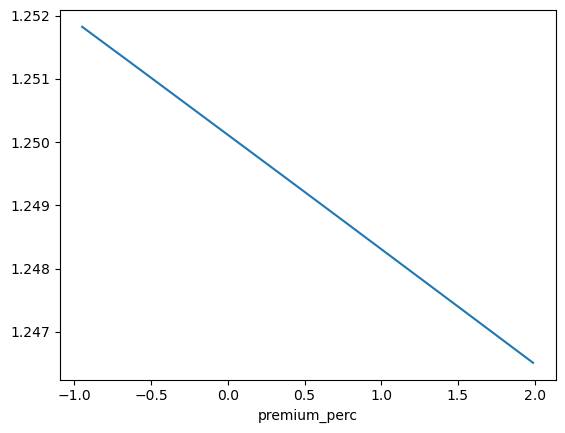

In [28]:
df_pred_results.groupby(['premium_perc'])['itt_hour_log_pred'].mean().plot()

In [29]:
''' save prediction results '''
df_pred_results.reset_index(drop=True).to_feather("../model/model_prediction_241016_v5.ftr")

# 14. Deep IV (241017 v1)
- add learning rate scheduler (learning rate decay by 50% after 10 epochs)
- 200 epochs

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  likes_count_cumsum_1k     VAE0      VAE1      VAE2  \
0                5.69036              53.713001  1.22469 -0.068803 -0.165689   
1                5.69036              53.713001  1.22469 -0.068803 -0.165689   
2                5.69036              53.713001  1.22469 -0.068803 -0.165689   
3                5.69036              53.713001  1.22469 -0.068803 -0.165689   
4                5.69036              53.713001  1.22469 -0.068803 -0.165689   

       VAE3      VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
0  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
1  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
2  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
3  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
4  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   

      VAE10     VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   

      VAE17     VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
0  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
1  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
2  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
3  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
4  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   

      VAE24     VAE25     VAE26     VAE27     VAE28     VAE29     VAE30  \
0  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
1  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
2  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
3  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
4  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   

      VAE31     VAE32     VAE33     VAE34     VAE35     VAE36     VAE37  \
0  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
1  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
2  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
3  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
4  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   

      VAE38     VAE39     VAE40     VAE41    VAE42     VAE43     VAE44  \
0  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
1  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
2  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
3  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
4  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   

      VAE45     VAE46     VAE47     VAE48     VAE49     VAE50    VAE51  \
0 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
1 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
2 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
3 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [17]:
x.shape

In [32]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
    
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1, activation='relu')
                                ])

def lr_scheduler(epoch):
    if epoch % 10 == 0:
        return 0.0000001 * (0.5 ** (epoch//10))
    else:
        return learning_rate

keras_fit_options = { "epochs": 200,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True), 
                                    keras.callbacks.LearningRateScheduler(lr_scheduler)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.0000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

In [33]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z)

Epoch 1/200
  1839/101517 [..............................] - ETA: 10:41 - loss: 1.0565


KeyboardInterrupt



In [ ]:
deepIvEst._effect_model.weights

In [ ]:
deepIvEst._d_y

In [ ]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241017_v1.h5")

## predict by product

In [23]:
''' products that used in the model '''
df_product_temp = df_product[df_product['product_id'].isin(df_model_org['product_id'].unique())].drop(columns=['itt_hour_ln', 'premium_perc', 'likes_count_cumsum', 'wish_closest_product'])

''' make columns for dummies '''
col_cat = [col for col in df_model_org.columns if 'category_1_'in col]
col_yyyy = [col for col in df_model_org.columns if 'yyyy_'in col]
col_mm = [col for col in df_model_org.columns if 'mm_'in col]
col_brand = [col for col in df_model_org.columns if 'brand_rename_'in col]

df_product_temp[col_cat] = 0
df_product_temp[col_yyyy] = 0
df_product_temp[col_mm] = 0
df_product_temp[col_brand] = 0

''' retain column orders '''
col_order = df_product_temp.columns

''' update brand, category, yyyymm '''
df_product_temp = df_product_temp.progress_apply(update_dummy_columns, axis=1)
df_product_temp = df_product_temp[col_order]
df_product_temp = df_product_temp.set_index('product_id')

''' drop unnecessary columns '''
df_product_temp = df_product_temp[[col for col in col_order if col != 'product_id']]

df_product_temp = df_product_temp.drop(columns=['brand_rename', 'category_1', 'yyyymm', 'yyyy', 'mm', 'option_rename'])

''' set as day it is released '''
df_product_temp['days_since_release_ln'] = 0
df_product_temp = df_product_temp[df_model_org.drop(columns=['product_id', 'itt_hour_ln', 'premium_perc', 'likes_count_cumsum_1k']).columns]

  0%|          | 0/45691 [00:00<?, ?it/s]

In [24]:
df_product_temp.head()

msrp_dollar_ln  with_release_date  days_since_release_ln  \
product_id                                                             
42258             4.986238                  1                      0   
42260             4.345801                  0                      0   
42264             4.345801                  1                      0   
42265             4.345801                  1                      0   
42267             3.559734                  0                      0   

                VAE0      VAE1      VAE2      VAE3      VAE4      VAE5  \
product_id                                                               
42258       1.050903  0.111212  1.969807  0.246390 -1.691035  0.429657   
42260      -1.738925  1.827212 -0.856622  0.113211  1.747071 -0.296775   
42264      -1.299457  0.878780  0.184898  0.791323 -0.357866 -0.494414   
42265      -2.419938  0.905033  0.281696 -0.900049  0.511693  1.126570   
42267      -2.057883 -0.494335 -0.015157 -0.787079  0.716884  2.681304   

                VAE6      VAE7      VAE8      VAE9     VAE10     VAE11  \
product_id                                                               
42258       0.948235 -0.536632 -1.214658 -0.964641  1.480959 -0.783705   
42260       0.624815 -1.126044 -1.021075  0.356013 -0.571247  2.460512   
42264       0.796174  1.631406  0.376148 -0.844294 -0.286660 -0.520856   
42265       0.176529  2.128669 -0.431294  0.625473  0.268541  0.764545   
42267       0.544064  1.506283  1.119234 -1.538718 -1.114949  0.461781   

               VAE12     VAE13     VAE14     VAE15     VAE16     VAE17  \
product_id                                                               
42258       0.466241 -0.688015 -0.412942 -0.143428 -0.314078 -0.618858   
42260      -0.971897  0.425472  1.226174  1.521232  0.047381 -1.149022   
42264       0.207794  0.388311  0.360393 -1.016000  0.201387  0.099013   
42265       0.166856 -1.415028  1.257951 -0.380420 -0.161390 -0.056215   
42267      -0.444077 -0.349623 -0.603524  0.124092 -0.593204 -0.416332   

               VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
product_id                                                               
42258       0.846497  0.046871 -0.369871  0.740456  0.270468 -3.159378   
42260      -0.584600  0.857650  0.634725  0.505800 -2.420990 -0.709899   
42264       0.068639 -0.755147  1.492694 -0.693865  0.641771 -0.081320   
42265      -0.933749  0.807526 -0.816335 -0.542718  0.195698 -0.251901   
42267      -0.919334  1.043153  1.249755  0.186249 -0.807491  0.413206   

               VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
product_id                                                               
42258      -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
42260      -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
42264      -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
42265      -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
42267       0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

               VAE30     VAE31     VAE32     VAE33     VAE34     VAE35  \
product_id                                                               
42258      -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188   
42260       0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845   
42264      -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256   
42265       0.404087 -0.199356  1.724285  0.789555  0.877525  0.491653   
42267       1.082721 -0.412045  0.877310  0.962479  0.013337  0.162370   

               VAE36     VAE37     VAE38     VAE39     VAE40     VAE41  \
product_id                                                               
42258       0.549174  1.383650 -0.624311 -0.903093 -1.980773 -1.410958   
42260      -2.168412 -0.198054 -0.060278 -0.402895 -2.182614 -2.512765   
42264      -0.166063  0.734578 -0.425735  0.942472  0.150544  0.766455   
42265      -0.328331 -0

In [25]:
df_product_temp.shape

In [27]:
dict_results = {}
t_range = np.arange(-0.95, 2.00, 0.01)
for prd in tqdm(df_product_temp.index[:100]):
    df_pred = pd.DataFrame([t_range, deepIvEst.predict(t_range, np.tile(df_product_temp.loc[prd], (len(t_range), 1)))]).T.rename(columns={0:'premium_perc', 1:'itt_hour_log_pred'})
    df_pred['itt_hour_log_pred'] = df_pred['itt_hour_log_pred'].str[0]
    df_pred['product_id'] = prd
    dict_results[prd] = df_pred
df_pred_results = pd.concat(dict_results.values())

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
df_pred_results = pd.concat(dict_results.values())
display(df_pred_results.head())
display(df_pred_results.tail())

In [ ]:
df_pred_results.groupby(['premium_perc'])['itt_hour_log_pred'].mean().plot()

In [30]:
''' save prediction results '''
df_pred_results.reset_index(drop=True).to_feather("../model/model_prediction_241017_v1.ftr")

# 15. Deep IV (used data v3, saved in 5_2_3 jupyter)

# 16. Deep IV (241018 v1)
- used data v2.1.0 (brand rename)
- 2 epochs for bootstrap
- add learning rate scheduler (learning rate decay by 50% after 10 epochs)

## load data

In [8]:
df_model = pd.read_feather('../data/DeepIV v2.1.0.ftr')
df_model = df_model[df_model['itt_hour_ln'].notnull()]

## prep data

In [11]:
''' organize product information '''
df_product = df_model.drop_duplicates(subset=['product_id', 'category_1', 'brand_rename'], keep='last').drop(columns=['txn_id', 'likes_count_cumsum_ln', 'wish_closest_product_ln'])

In [12]:
df_product.head()

product_id   yyyymm  yyyy  mm category_1 option_rename brand_rename  \
11752       42258  2022-03  2022  03      shoes           275        Asics   
11815       42260  2021-10  2021  10      shoes           265     Converse   
11844       42264  2022-03  2022  03      shoes           260     Converse   
11860       42265  2022-03  2022  03      shoes           240     Converse   
11866       42267  2021-10  2021  10  accessory      ONE SIZE         Nike   

       itt_hour_ln  premium_perc  msrp_dollar_ln  brand_likes_ln  \
11752     6.718205     -0.047619        4.986238        9.569482   
11815     7.294702     -0.141414        4.345801        8.045588   
11844     3.972030     -0.232323        4.345801        8.045588   
11860     6.389988     -0.121212        4.345801        8.045588   
11866     6.917406      0.238739        3.559734       10.735875   

       with_release_date  days_since_release_ln  likes_count_cumsum  \
11752                  1               6.538140                 0.0   
11815                  0               0.000000                 0.0   
11844                  1               5.099866               618.0   
11860                  1               5.105945                 0.0   
11866                  0               0.000000                 0.0   

       wish_closest_product  likes_count_cumsum_1k      VAE0      VAE1  \
11752                  1194                  0.000  1.050903  0.111212   
11815                   619                  0.000 -1.738925  1.827212   
11844                   884                  0.618 -1.299457  0.878780   
11860                  1172                  0.000 -2.419938  0.905033   
11866                    55                  0.000 -2.057883 -0.494335   

           VAE2      VAE3      VAE4      VAE5      VAE6      VAE7      VAE8  \
11752  1.969807  0.246390 -1.691035  0.429657  0.948235 -0.536632 -1.214658   
11815 -0.856622  0.113211  1.747071 -0.296775  0.624815 -1.126044 -1.021075   
11844  0.184898  0.791323 -0.357866 -0.494414  0.796174  1.631406  0.376148   
11860  0.281696 -0.900049  0.511693  1.126570  0.176529  2.128669 -0.431294   
11866 -0.015157 -0.787079  0.716884  2.681304  0.544064  1.506283  1.119234   

           VAE9     VAE10     VAE11     VAE12     VAE13     VAE14     VAE15  \
11752 -0.964641  1.480959 -0.783705  0.466241 -0.688015 -0.412942 -0.143428   
11815  0.356013 -0.571247  2.460512 -0.971897  0.425472  1.226174  1.521232   
11844 -0.844294 -0.286660 -0.520856  0.207794  0.388311  0.360393 -1.016000   
11860  0.625473  0.268541  0.764545  0.166856 -1.415028  1.257951 -0.380420   
11866 -1.538718 -1.114949  0.461781 -0.444077 -0.349623 -0.603524  0.124092   

          VAE16     VAE17     VAE18     VAE19     VAE20     VAE21     VAE22  \
11752 -0.314078 -0.618858  0.846497  0.046871 -0.369871  0.740456  0.270468   
11815  0.047381 -1.149022 -0.584600  0.857650  0.634725  0.505800 -2.420990   
11844  0.201387  0.099013  0.068639 -0.755147  1.492694 -0.693865  0.641771   
11860 -0.161390 -0.056215 -0.933749  0.807526 -0.816335 -0.542718  0.195698   
11866 -0.593204 -0.416332 -0.919334  1.043153  1.249755  0.186249 -0.807491   

          VAE23     VAE24     VAE25     VAE26     VAE27     VAE28     VAE29  \
11752 -3.159378 -0.857469  1.588793 -1.217684 -0.428428  0.095805  0.724780   
11815 -0.709899 -1.552438 -0.308961  0.159000 -0.196066  1.478492  0.908951   
11844 -0.081320 -0.586836 -1.274949 -1.367260  0.238145 -1.179935  1.465048   
11860 -0.251901 -0.113923  1.278561  0.010408  0.573411 -1.059691 -0.756559   
11866  0.413206  0.326702 -0.440276  1.471142 -0.763708 -1.095503 -1.093471   

          VAE30     VAE31     VAE32     VAE33     VAE34     VAE35     VAE36  \
11752 -0.987395 -0.336328 -1.300317  1.505193  0.136826 -0.682188  0.549174   
11815  0.910422 -1.997564 -1.489222  0.377437 -0.054294 -0.430845 -2.168412   
11844 -1.077840  0.644268 -0.814113  0.753098  0.812587  0.005256 -0.166063   
11860  0.404087 -0.199356  1.724285  0.78

In [13]:
''' oragnize columns and make dummy columns '''
df_model_org = df_model[['product_id', 
                         'itt_hour_ln', # DV
                         'premium_perc', # IV
                         'category_1', 'yyyy', 'mm', 'brand_rename',  # Dummies
                         'msrp_dollar_ln', 'with_release_date', 'days_since_release_ln', # independent variables
                         'likes_count_cumsum_1k' # instrumental variable
                        ] + [col for col in df_model.columns if "VAE" in col] # product vector
]
df_model_org = optimize(pd.get_dummies(df_model_org, columns=['category_1', 'yyyy' ,'mm', 'brand_rename'],  dtype=np.int8))

In [14]:
print(df_model_org.shape)
df_model_org.head()

(16242602, 330)


product_id  itt_hour_ln  premium_perc  msrp_dollar_ln  with_release_date  \
0       42255     0.065580      0.278539        5.132626                  1   
1       42255     1.176173      0.347032        5.132626                  1   
2       42255     1.113683      0.342466        5.132626                  1   
3       42255     1.479329      0.315068        5.132626                  1   
4       42255     1.332659      0.242009        5.132626                  1   

   days_since_release_ln  likes_count_cumsum_1k     VAE0      VAE1      VAE2  \
0                5.69036              53.713001  1.22469 -0.068803 -0.165689   
1                5.69036              53.713001  1.22469 -0.068803 -0.165689   
2                5.69036              53.713001  1.22469 -0.068803 -0.165689   
3                5.69036              53.713001  1.22469 -0.068803 -0.165689   
4                5.69036              53.713001  1.22469 -0.068803 -0.165689   

       VAE3      VAE4      VAE5      VAE6      VAE7      VAE8      VAE9  \
0  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
1  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
2  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
3  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   
4  0.231437 -1.084858  0.256292  0.415015 -0.227768 -0.888845 -0.777399   

      VAE10     VAE11     VAE12     VAE13     VAE14     VAE15     VAE16  \
0  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
1  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
2  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
3  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   
4  0.636129 -2.119525 -0.447786  0.089478 -0.502632  0.050769 -0.654228   

      VAE17     VAE18     VAE19     VAE20     VAE21     VAE22     VAE23  \
0  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
1  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
2  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
3  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   
4  0.327182 -0.983476  1.273388  0.420625  0.321297  0.336137  0.895122   

      VAE24     VAE25     VAE26     VAE27     VAE28     VAE29     VAE30  \
0  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
1  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
2  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
3  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   
4  0.630526  0.752017  1.151641  0.536488 -0.373947 -0.356338  0.716691   

      VAE31     VAE32     VAE33     VAE34     VAE35     VAE36     VAE37  \
0  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
1  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
2  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
3  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   
4  1.870043 -0.841526  0.212666  1.716576  0.692349  0.802514  0.975076   

      VAE38     VAE39     VAE40     VAE41    VAE42     VAE43     VAE44  \
0  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
1  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
2  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
3  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   
4  0.112449  2.155179  0.960115 -0.547129 -0.17001 -1.035996 -0.439908   

      VAE45     VAE46     VAE47     VAE48     VAE49     VAE50    VAE51  \
0 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
1 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
2 -1.346315  0.072468  0.056531  0.257154 -0.082497  0.337566 -0.31292   
3 -1.346315  0.072468  0.056531  0.257154 -0.082497

In [15]:
''' NA check '''
df_model_org.isnull().sum().sum()

0

## train model

In [16]:
y = df_model_org[['itt_hour_ln']].values
t = df_model_org[['premium_perc']].values
x = df_model_org.drop(columns=['product_id', 
                                'itt_hour_ln', # y
                                'premium_perc', # x
                                'likes_count_cumsum_1k', # instrumental variable
                               ]).values
z = df_model_org[['likes_count_cumsum_1k']].values

In [17]:
x.shape

In [32]:
treatment_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
    
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                ])

response_model = keras.Sequential([
                                    keras.layers.Dense(128, activation='relu', input_shape=(x.shape[1] + 1,)),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Dropout(0.2),
                                
                                    keras.layers.Dense(1, activation='relu')
                                ])

def scheduler(epoch, lr):
    if epoch % 10 == 0:
        return lr * (0.5 ** (epoch//10))
    else:
        return lr

keras_fit_options = { "epochs": 2,
                      "validation_split": 0.2,
                      "batch_size": 128,
                      'verbose':1, 
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True), 
                                    keras.callbacks.LearningRateScheduler(scheduler)]}

deepIvEst = DeepIV(n_components = 10, # number of gaussians in our mixture density network
                   m = lambda z, x : treatment_model(keras.layers.concatenate([z, x])), # treatment model
                   h = lambda t, x : response_model(keras.layers.concatenate([t, x])),  # response model
                   n_samples = 1, # number of samples to use to estimate the response
                   use_upper_bound_loss = False, # whether to use an approximation to the true loss
                   n_gradient_samples = 1, # number of samples to use in second estimate of the response
                                           # (to make loss estimate unbiased)
                   optimizer=Adam(learning_rate=0.0000001, clipvalue=1.0), 
                   first_stage_options = keras_fit_options, # options for training treatment model
                   second_stage_options = keras_fit_options) # options for training response model

In [33]:
deepIvEst.fit(Y=y, T=t, X=x, Z=z, inference='bootstrap')

Epoch 1/200
  1839/101517 [..............................] - ETA: 10:41 - loss: 1.0565


KeyboardInterrupt



In [ ]:
deepIvEst._effect_model.weights

In [ ]:
deepIvEst._d_y

In [ ]:
deepIvEst._effect_model.save("../model/DeepIV_effect_model_241018_v1.h5")

## predict by product

In [ ]:
''' get unique premium of real transactions '''
df_uniq_txn_premium = df_model_org.drop_duplicates(subset=['product_id', 'premium_perc']).drop(columns=['product_id', 'itt_hour_ln', 'likes_count_cumsum_1k'])

In [ ]:
''' predicted ITT '''
pred_itt = deepIvEst.predict(np.array(df_uniq_txn_premium['premium_perc'].values.reshape(-1, )), 
                              np.array(df_uniq_txn_premium.drop(columns=['premium_perc']).values))

''' make as DataFrame '''
df_pred_results = pd.DataFrame(pred_itt).rename(columns={0:'itt_hour_log_pred'})
df_pred_results.insert(0, 'premium_perc', df_uniq_txn_premium['premium_perc'].values)

In [ ]:
display(df_pred_results.head())
display(df_pred_results.tail())

In [ ]:
df_pred_results[['itt_hour_log_pred', 'premium_perc']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

In [ ]:
df_pred_results.groupby('premium_perc_r2')['itt_hour_log_pred'].mean().plot()